In [509]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.seasonal
import matplotlib
import scipy
from fractions import Fraction

from datetime import timedelta

In [166]:
def fft(x,dt=1):
    xhat = scipy.fft.fft(x)
    xhat = xhat[:len(xhat)//2]
    f = scipy.fft.fftfreq(n=len(x),d=dt)
    f = f[:len(f)//2]
    A = 2/len(xhat)*np.abs(xhat)

    return f, xhat, A

In [4]:
# full dataset can be found here: https://www.kaggle.com/datasets/vetrirah/ml-iot
data_dir = Path('ml-iot')

In [45]:
df = pd.read_csv(data_dir / 'train_ML_IOT.csv')
subdf = df[df.Junction == 1]

# extract full year
x = subdf.Vehicles.values[:24*365]


In [31]:
font = 'Ubuntu Condensed'

sns.set_theme(style='dark',font=font)

col_lines = 'white'
basic_color = 'oldlace'
tick_color = 'wheat'
colorK = 'indigo'
colorL = 'khaki'
fig_bg_color = 'dimgray'
ax_bg_color = 'gray'

matplotlib.rcParams.update({'text.color' : basic_color,
                            'axes.titlecolor' : basic_color,
                            'xtick.color' : tick_color,
                            'ytick.color' : tick_color,
                            'axes.labelcolor' : basic_color,
                            'axes.facecolor' : ax_bg_color,
                            'legend.facecolor': fig_bg_color,
                            'figure.facecolor': fig_bg_color,
                            'text.usetex': False})


In [457]:
signal_color = 'black'
trend_color = 'darkorange'
seasonal_color = 'lightyellow'
seasonal_2_color = 'greenyellow'
noise_color = 'lightblue'

## time series

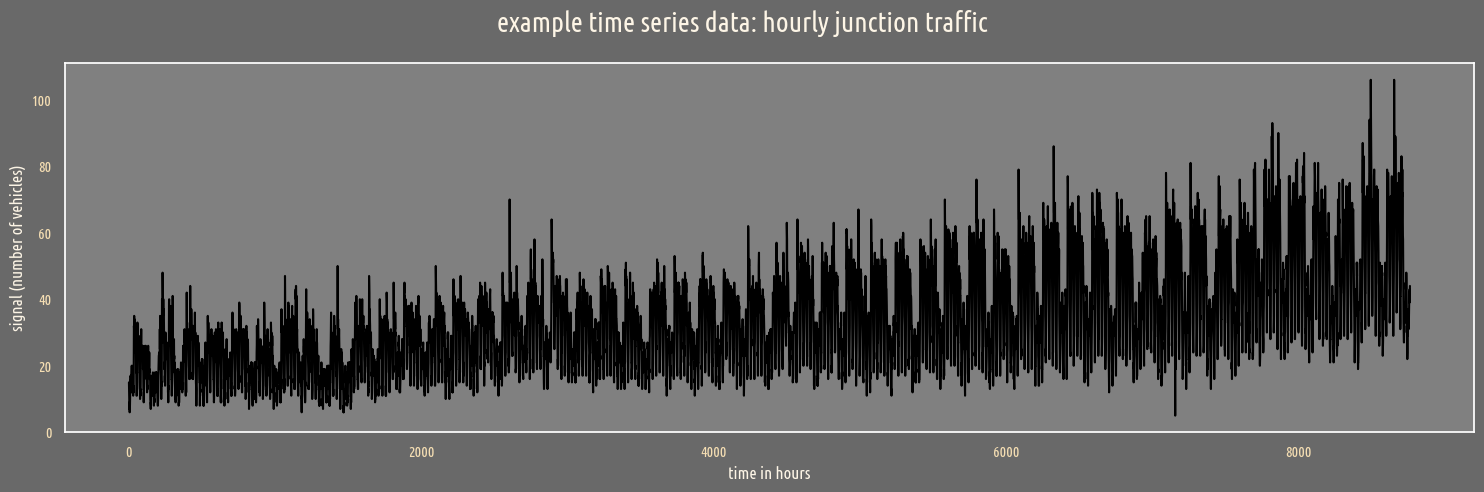

In [33]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(x, color = signal_color)
ax.set_ylabel('signal (number of vehicles)')
ax.set_xlabel('time in hours')
fig.suptitle('example time series data: hourly junction traffic', fontsize = 20)
fig.tight_layout()

fig.savefig('fig1.png')

## seasonal_decompose

In [539]:
period = 24*7
sd = statsmodels.tsa.seasonal.seasonal_decompose(x, period = period, extrapolate_trend = 'freq')

### decomposition

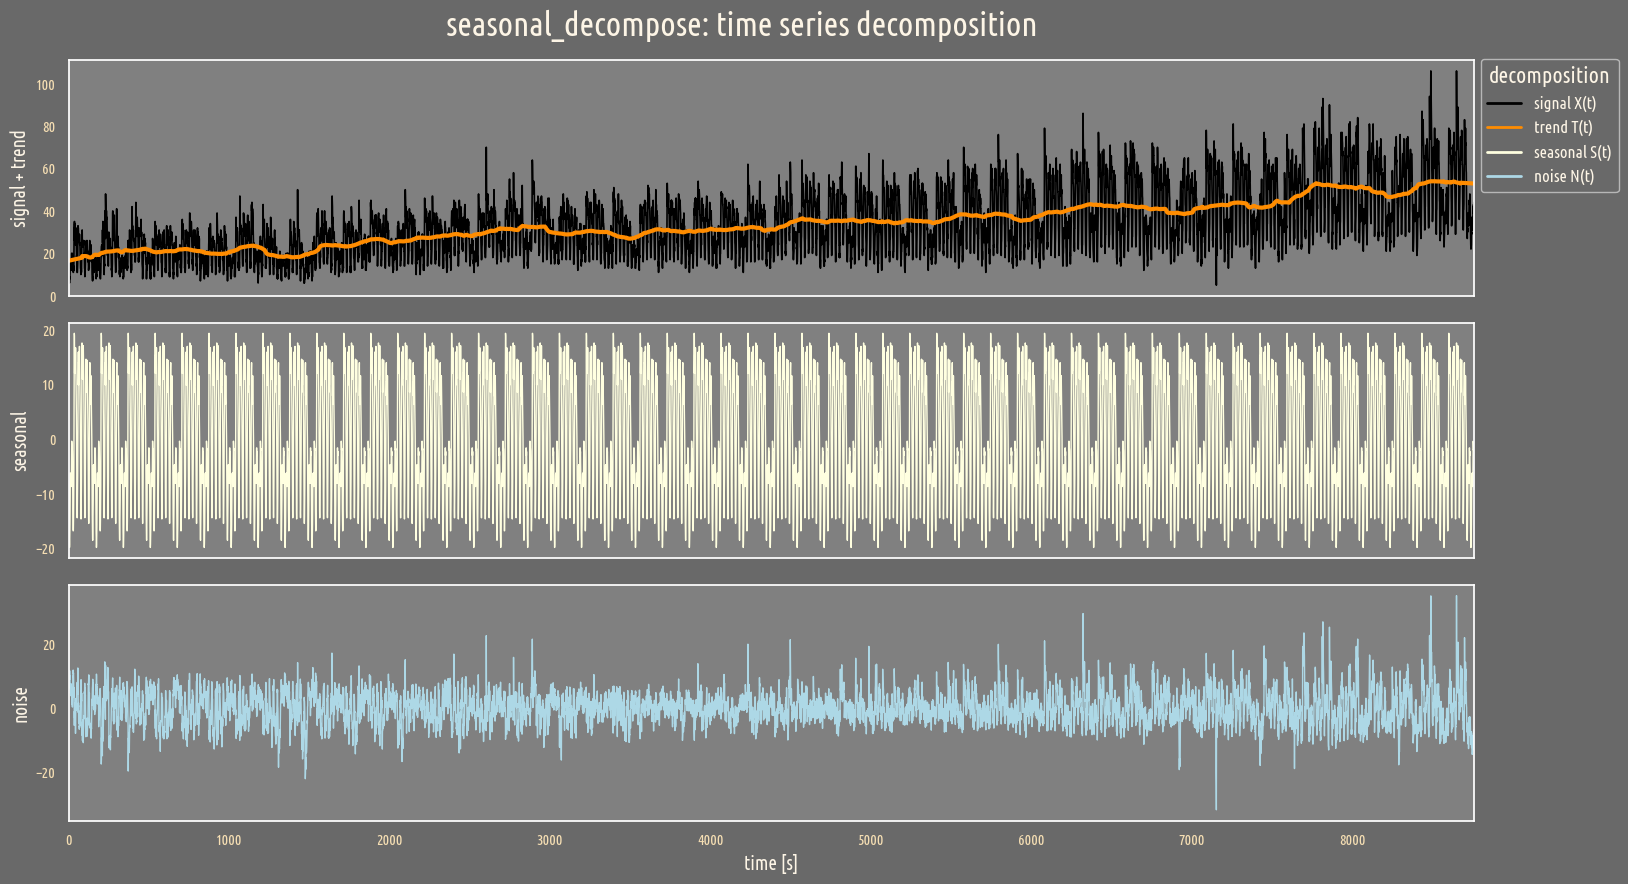

In [540]:
nrows = 3
ncols = 1
fig, axs = plt.subplots(ncols = ncols, nrows=nrows, figsize=(ncols*15,nrows*3), sharex = True)
# fig.set_facecolor("dimgray")

ax = axs[0]
ax.plot(sd.observed, lw = 1.2, color=signal_color, label = 'signal X(t)')
ax.plot(sd.trend, lw=3, color=trend_color, label='trend T(t)')
ax.set_ylabel('signal + trend', fontsize = 14)

ax.set_xlim(0, len(sd.observed))

ax = axs[1]
ax.plot(sd.seasonal, lw=1, color=seasonal_color, label='seasonal S(t)')
ax.set_ylabel('seasonal', fontsize = 14)

ax = axs[2]
ax.plot(sd.resid, lw=1, color = noise_color, label='noise N(t)')
ax.set_ylabel('noise', fontsize = 14)
ax.set_xlabel('time [s]',fontsize = 14)


leg = fig.legend(title='decomposition',bbox_to_anchor = (1.09,.935),title_fontsize = 16,fontsize=12)

for line in leg.get_lines():
    line.set_linewidth(2.0)
    
fig.suptitle('seasonal_decompose: time series decomposition', fontsize=24)
fig.tight_layout()

fig.savefig('sd.png',bbox_inches = 'tight')

### Fourier

In [541]:
f,xhat_observed,A_observed = fft(sd.observed)
f,xhat_trend,A_trend = fft(sd.trend)
f,xhat_seasonal, A_seasonal = fft(sd.seasonal)
f, xhat_resid, A_resid = fft(sd.resid)

In [542]:
A = np.stack([A_trend,A_seasonal,A_resid])
A_ix = A.argmax(axis=0)
mask_trend = A_ix == 0
mask_seasonal = A_ix == 1
mask_resid = A_ix == 2


In [543]:
nn = 5
A_observed_ma = scipy.signal.convolve(A_observed,[1/nn]*nn, mode = 'same')
A_trend_ma = scipy.signal.convolve(A_trend,[1/nn]*nn, mode = 'same')
A_seasonal_ma = scipy.signal.convolve(A_seasonal,[1/nn]*nn, mode = 'same')
A_resid_ma = scipy.signal.convolve(A_resid,[1/nn]*nn, mode = 'same')

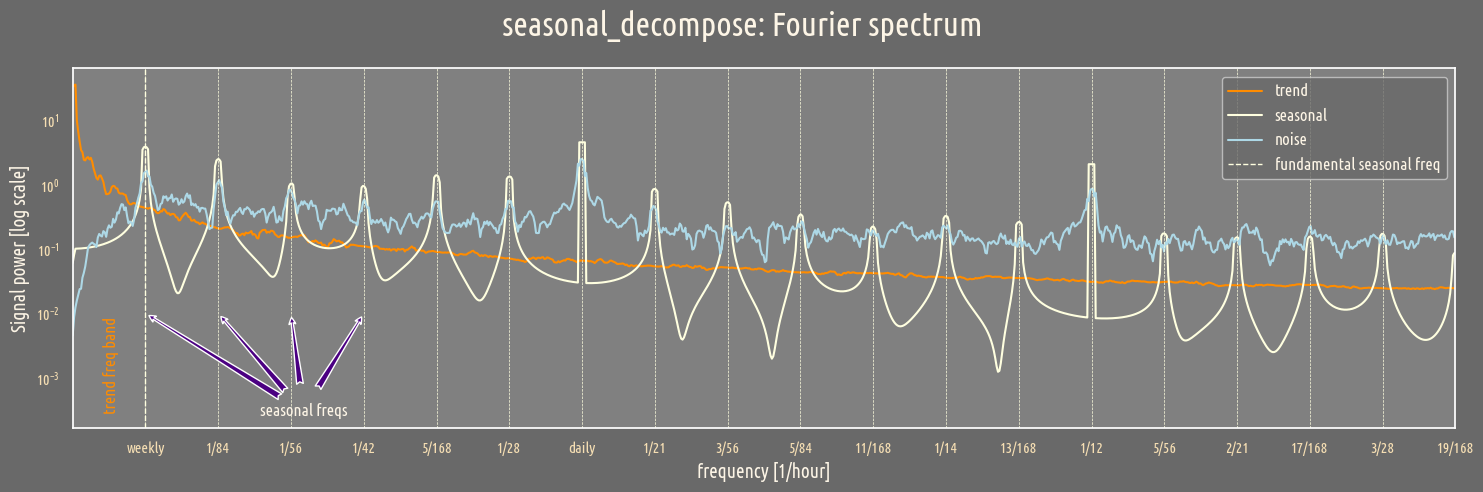

In [544]:
masks = [mask_trend,mask_seasonal,mask_resid]
A_ma = [A_trend_ma,A_seasonal_ma, A_resid_ma]
A_ = [A_trend,A_seasonal, A_resid]
colors = [trend_color, seasonal_color, noise_color]
labels = ['trend','seasonal','noise']
fig, ax = plt.subplots(figsize=(15,5))
# ax.plot(f,A_observed_ma, lw= 0.8, color = signal_color)
# ax.plot(f,np.max(A,axis=0))
for mask, A, color,label in zip(masks, A_ma, colors, labels):
    # ax.plot(f[mask],A_observed_ma[mask],'.',color = color)
    ax.plot(f,A,color = color, label = label)

# ax.plot(f[mask_trend],A_trend[mask_trend],'.', color = trend_color)
# ax.plot(f[mask_seasonal],A_seasonal[mask_seasonal],'.', color = seasonal_color)
# ax.plot(f[mask_resid],A_resid[mask_resid],'.', color = noise_color)
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0,0.1)

ax.axvline(1/period,ymin=1e-5,ymax=1e2, color = seasonal_color, ls='--',lw=1, label = 'fundamental seasonal freq')

for i in range(1,20):
    ax.axvline(i/period,ymin=1e-5,ymax=1e2, color = seasonal_color, ls='--',lw=0.5)
    
    
ax.annotate(text='trend freq band',xy=(0.0025,3e-4),color = trend_color, rotation='vertical')

arrowprops = dict(facecolor=colorK,
                  arrowstyle = 'fancy',
                  
                  shrinkB = 3,
                  shrinkA = 20)

meanperiod = 1/2*(1/period + 4/period)+0.004
for i in range(1,5):
    ax.annotate(text = None, xy = (i/period,1e-2), xytext =(meanperiod,3e-4), arrowprops=arrowprops)

ax.text(s = 'seasonal freqs', x =meanperiod, y = 3e-4,horizontalalignment='center',
        verticalalignment='center')

ax.legend(fontsize=12, loc = 1)

ax.set_xticks([i/(24*7) for i in range(1,20)])
def conv_frac(frac):
    if frac == (1,168):
        return 'weekly'
    elif frac == (1,24):
        return 'daily'
    else:
        return f'{frac[0]}/{frac[1]}'

ax.set_xticklabels([conv_frac(Fraction(i,24*7).as_integer_ratio()) for i in range(1,20)])


ax.set_xlabel('frequency [1/hour]', fontsize = 14)
ax.set_ylabel('Signal power [log scale]', fontsize = 14)

fig.suptitle('seasonal_decompose: Fourier spectrum', fontsize=24)
fig.tight_layout()
fig.savefig('sd_fourier.png',bbox_inches = 'tight')

## STL

In [545]:
period = 24*7
trend = period*2 + 1
seasonal = 7
stl = statsmodels.tsa.seasonal.STL(endog = x,period = period,trend = trend,seasonal = seasonal)
stl = stl.fit()

### decomposition

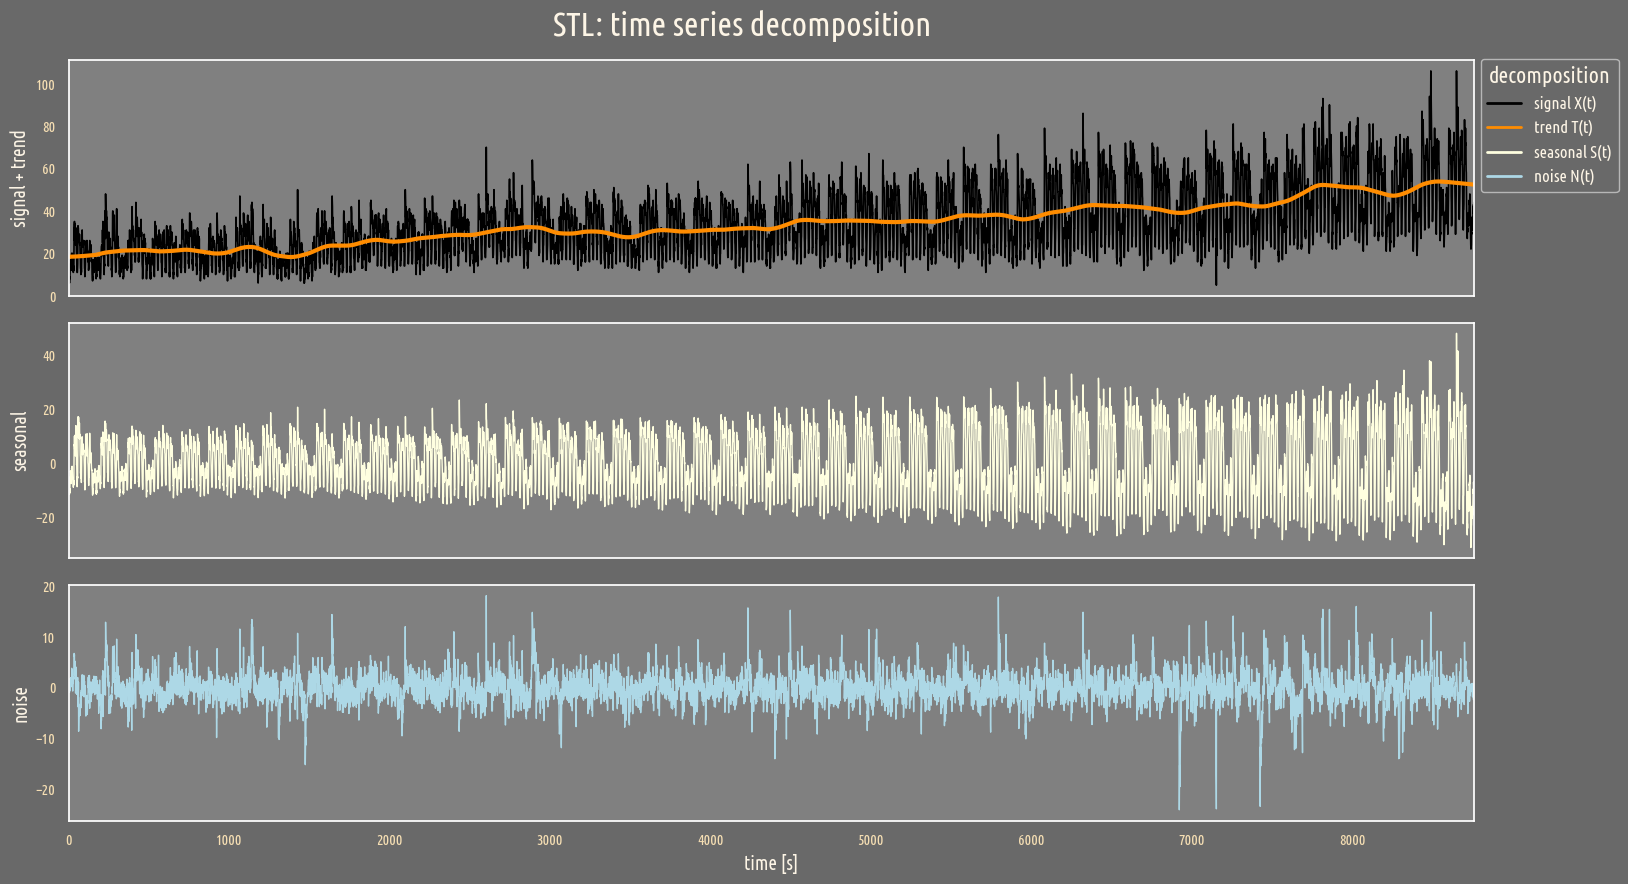

In [546]:
nrows = 3
ncols = 1
fig, axs = plt.subplots(ncols = ncols, nrows=nrows, figsize=(ncols*15,nrows*3), sharex = True)
# fig.set_facecolor("dimgray")

ax = axs[0]
ax.plot(stl.observed, lw = 1.2, color=signal_color, label = 'signal X(t)')
ax.plot(stl.trend, lw=3, color=trend_color, label='trend T(t)')
ax.set_ylabel('signal + trend', fontsize = 14)

ax.set_xlim(0, len(stl.observed))

ax = axs[1]
ax.plot(stl.seasonal, lw=1, color=seasonal_color, label='seasonal S(t)')
ax.set_ylabel('seasonal', fontsize = 14)

ax = axs[2]
ax.plot(stl.resid, lw=1, color = noise_color, label='noise N(t)')
ax.set_ylabel('noise', fontsize = 14)
ax.set_xlabel('time [s]',fontsize = 14)


leg = fig.legend(title='decomposition',bbox_to_anchor = (1.09,.935),title_fontsize = 16,fontsize=12)

for line in leg.get_lines():
    line.set_linewidth(2.0)
    
fig.suptitle('STL: time series decomposition', fontsize=24)
fig.tight_layout()

fig.savefig('stl.png',bbox_inches = 'tight')

### Fourier

In [547]:
f,xhat_observed,A_observed = fft(stl.observed)
f,xhat_trend,A_trend = fft(stl.trend)
f,xhat_seasonal, A_seasonal = fft(stl.seasonal)
f, xhat_resid, A_resid = fft(stl.resid)

In [548]:
A = np.stack([A_trend,A_seasonal,A_resid])
A_ix = A.argmax(axis=0)
mask_trend = A_ix == 0
mask_seasonal = A_ix == 1
mask_resid = A_ix == 2


In [549]:
nn = 5
A_observed_ma = scipy.signal.convolve(A_observed,[1/nn]*nn, mode = 'same')
A_trend_ma = scipy.signal.convolve(A_trend,[1/nn]*nn, mode = 'same')
A_seasonal_ma = scipy.signal.convolve(A_seasonal,[1/nn]*nn, mode = 'same')
A_resid_ma = scipy.signal.convolve(A_resid,[1/nn]*nn, mode = 'same')

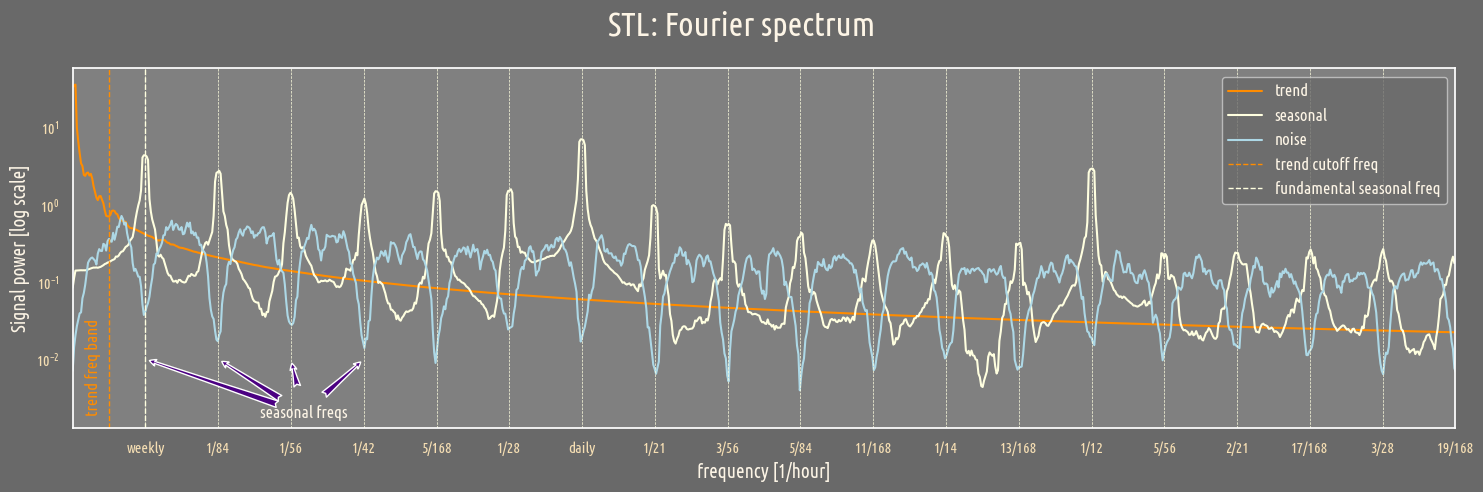

In [550]:
masks = [mask_trend,mask_seasonal,mask_resid]
A_ma = [A_trend_ma,A_seasonal_ma, A_resid_ma]
A_ = [A_trend,A_seasonal, A_resid]
colors = [trend_color, seasonal_color, noise_color]
labels = ['trend','seasonal','noise']
fig, ax = plt.subplots(figsize=(15,5))
# ax.plot(f,A_observed_ma, lw= 0.8, color = signal_color)
# ax.plot(f,np.max(A,axis=0))
for mask, A, color,label in zip(masks, A_ma, colors, labels):
    # ax.plot(f[mask],A_observed_ma[mask],'.',color = color)
    ax.plot(f,A,color = color, label = label)

# ax.plot(f[mask_trend],A_trend[mask_trend],'.', color = trend_color)
# ax.plot(f[mask_seasonal],A_seasonal[mask_seasonal],'.', color = seasonal_color)
# ax.plot(f[mask_resid],A_resid[mask_resid],'.', color = noise_color)
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0,0.1)

ax.axvline(1/trend,ymin=1e-5,ymax=1e2, color = trend_color, ls='--',lw=1, label = 'trend cutoff freq')
ax.axvline(1/period,ymin=1e-5,ymax=1e2, color = seasonal_color, ls='--',lw=1, label = 'fundamental seasonal freq')

for i in range(1,20):
    ax.axvline(i/period,ymin=1e-5,ymax=1e2, color = seasonal_color, ls='--',lw=0.5)
    
y0 = 2e-3  
ax.annotate(text='trend freq band',xy=(0.001,y0),color = trend_color, rotation='vertical')

arrowprops = dict(facecolor=colorK,
                  arrowstyle = 'fancy',
                  
                  shrinkB = 3,
                  shrinkA = 20)

meanperiod = 1/2*(1/period + 4/period)+0.004

for i in range(1,5):
    ax.annotate(text = None, xy = (i/period,1e-2), xytext =(meanperiod,y0), arrowprops=arrowprops)

ax.text(s = 'seasonal freqs', x =meanperiod, y = y0,horizontalalignment='center',
        verticalalignment='center')

ax.legend(fontsize=12, loc = 1)

ax.set_xticks([i/(24*7) for i in range(1,20)])
def conv_frac(frac):
    if frac == (1,168):
        return 'weekly'
    elif frac == (1,24):
        return 'daily'
    else:
        return f'{frac[0]}/{frac[1]}'

ax.set_xticklabels([conv_frac(Fraction(i,24*7).as_integer_ratio()) for i in range(1,20)])


ax.set_xlabel('frequency [1/hour]', fontsize = 14)
ax.set_ylabel('Signal power [log scale]', fontsize = 14)

fig.suptitle('STL: Fourier spectrum', fontsize=24)
fig.tight_layout()
fig.savefig('stl_fourier.png',bbox_inches = 'tight')

## SD vs STL

In [412]:
period = 24*7
sd = statsmodels.tsa.seasonal.seasonal_decompose(x, period = period, extrapolate_trend = 'freq')

In [413]:
period = 24*7
trend = period*2 + 1
seasonal = 7
stl = statsmodels.tsa.seasonal.STL(endog = x,period = period,trend = trend,seasonal = seasonal)
stl = stl.fit()

In [414]:
f,xhat_observed,A_observed_sd = fft(sd.observed)
f,xhat_trend,A_trend_sd = fft(sd.trend)
f,xhat_seasonal, A_seasonal_sd = fft(sd.seasonal)
f, xhat_resid, A_resid_sd = fft(sd.resid)

In [415]:
f,xhat_observed,A_observed_stl = fft(stl.observed)
f,xhat_trend,A_trend_stl = fft(stl.trend)
f,xhat_seasonal, A_seasonal_stl = fft(stl.seasonal)
f, xhat_resid, A_resid_stl = fft(stl.resid)

In [406]:
# A_stl = np.stack([A_trend,A_seasonal,A_resid_stl])
# A_ix = A.argmax(axis=0)
# mask_trend = A_ix == 0
# mask_seasonal = A_ix == 1
# mask_resid = A_ix == 2


In [416]:
nn = 5
A_observed_sd_ma = scipy.signal.convolve(A_observed_sd,[1/nn]*nn, mode = 'same')
A_trend_sd_ma = scipy.signal.convolve(A_trend_sd,[1/nn]*nn, mode = 'same')
A_seasonal_sd_ma = scipy.signal.convolve(A_seasonal_sd,[1/nn]*nn, mode = 'same')
A_resid_sd_ma = scipy.signal.convolve(A_resid_sd,[1/nn]*nn, mode = 'same')

A_observed_stl_ma = scipy.signal.convolve(A_observed_stl,[1/nn]*nn, mode = 'same')
A_trend_stl_ma = scipy.signal.convolve(A_trend_stl,[1/nn]*nn, mode = 'same')
A_seasonal_stl_ma = scipy.signal.convolve(A_seasonal_stl,[1/nn]*nn, mode = 'same')
A_resid_stl_ma = scipy.signal.convolve(A_resid_stl,[1/nn]*nn, mode = 'same')



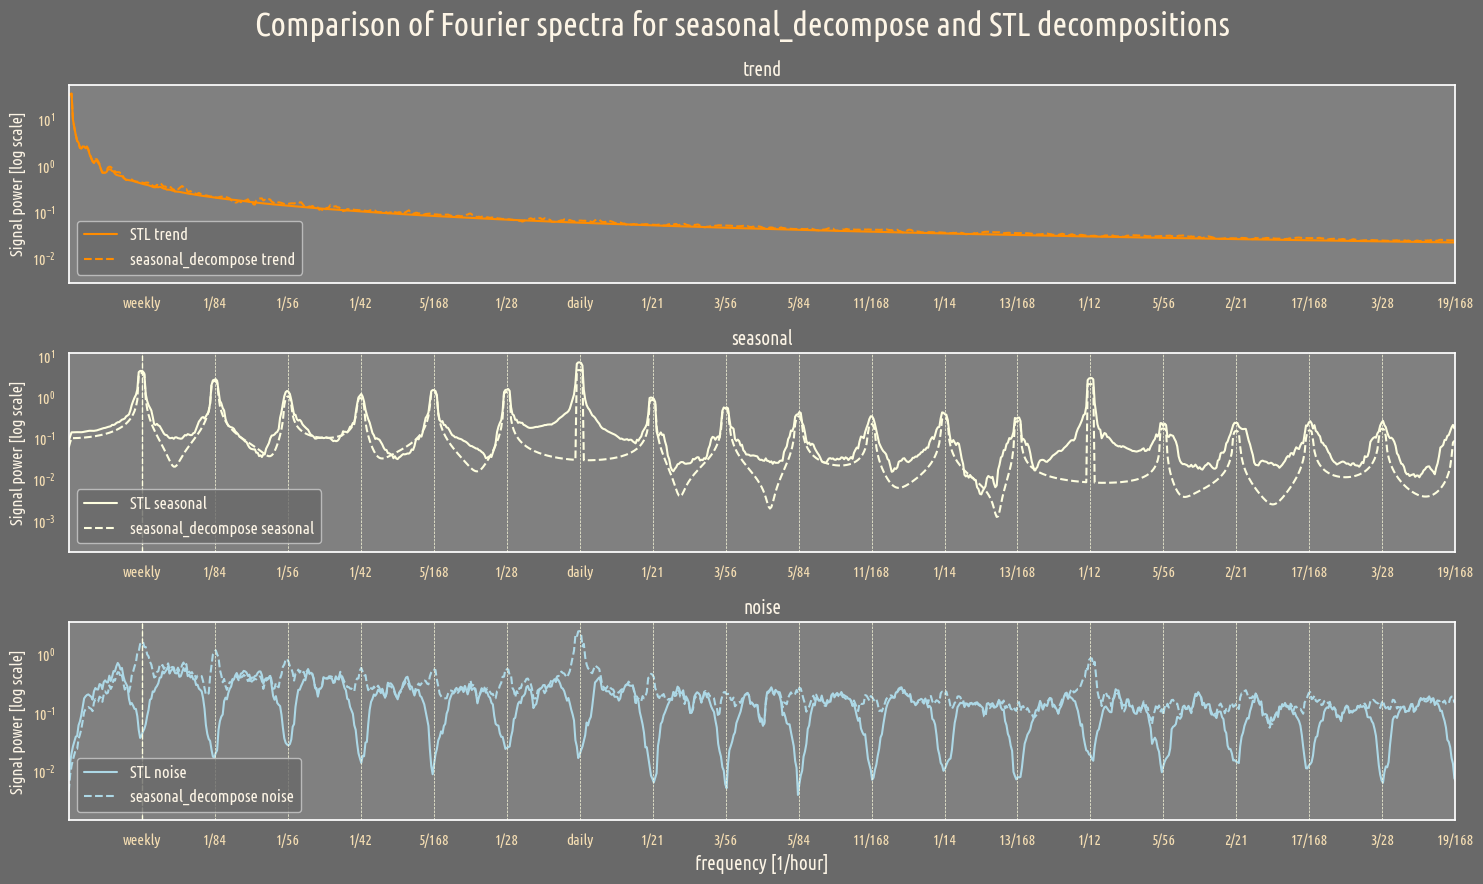

In [524]:

A_sd_ma = [A_trend_sd_ma,A_seasonal_sd_ma, A_resid_sd_ma]
A_stl_ma = [A_trend_stl_ma,A_seasonal_stl_ma, A_resid_stl_ma]

# A_ = [A_trend,A_seasonal, A_resid]
colors = [trend_color, seasonal_color, noise_color]
labels = ['trend','seasonal','noise']

nrows = 3
fig, axs = plt.subplots(nrows = nrows, figsize=(15,3*nrows))
# ax.plot(f,A_observed_ma, lw= 0.8, color = signal_color)
# ax.plot(f,np.max(A,axis=0))
for ax, A_sd, A_stl, color,label in zip(axs, A_sd_ma, A_stl_ma, colors, labels):
    # ax.plot(f[mask],A_observed_ma[mask],'.',color = color)
    ax.plot(f,A_stl,'-',color = color, label = f'STL {label}')
    ax.plot(f,A_sd,'--',color = color, label = f'seasonal_decompose {label}')
    ax.set_yscale('log')
    ax.set_xlim(0,0.1)
    ax.legend(loc = 3, fontsize=12)
    ax.set_ylabel('Signal power [log scale]', fontsize = 12)
    ax.set_title(label, fontsize = 14)
 
    ax.set_xticks([i/(24*7) for i in range(1,20)])
    def conv_frac(frac):
        if frac == (1,168):
            return 'weekly'
        elif frac == (1,24):
            return 'daily'
        else:
            return f'{frac[0]}/{frac[1]}'

    ax.set_xticklabels([conv_frac(Fraction(i,24*7).as_integer_ratio()) for i in range(1,20)])


for ax in axs[1:]:
    ax.axvline(1/period,ymin=1e-5,ymax=1e2, color = seasonal_color, ls='--',lw=1, label = 'fundamental seasonal freq')
    for i in range(1,20):
        ax.axvline(i/period,ymin=1e-5,ymax=1e2, color = seasonal_color, ls='--',lw=0.5)

ax = axs[-1]

ax.set_xlabel('frequency [1/hour]', fontsize = 14)


fig.suptitle('Comparison of Fourier spectra for seasonal_decompose and STL decompositions', fontsize=24)
fig.tight_layout()

fig.savefig('comparison.png')

## MSTL

In [473]:
periods = [24,24*7]
trend = max(periods)*2+1
windows = [7, 7]
mstl = statsmodels.tsa.seasonal.MSTL(endog = x,periods = periods, windows= windows, stl_kwargs = dict(trend = trend))
mstl = mstl.fit()

### decomposition

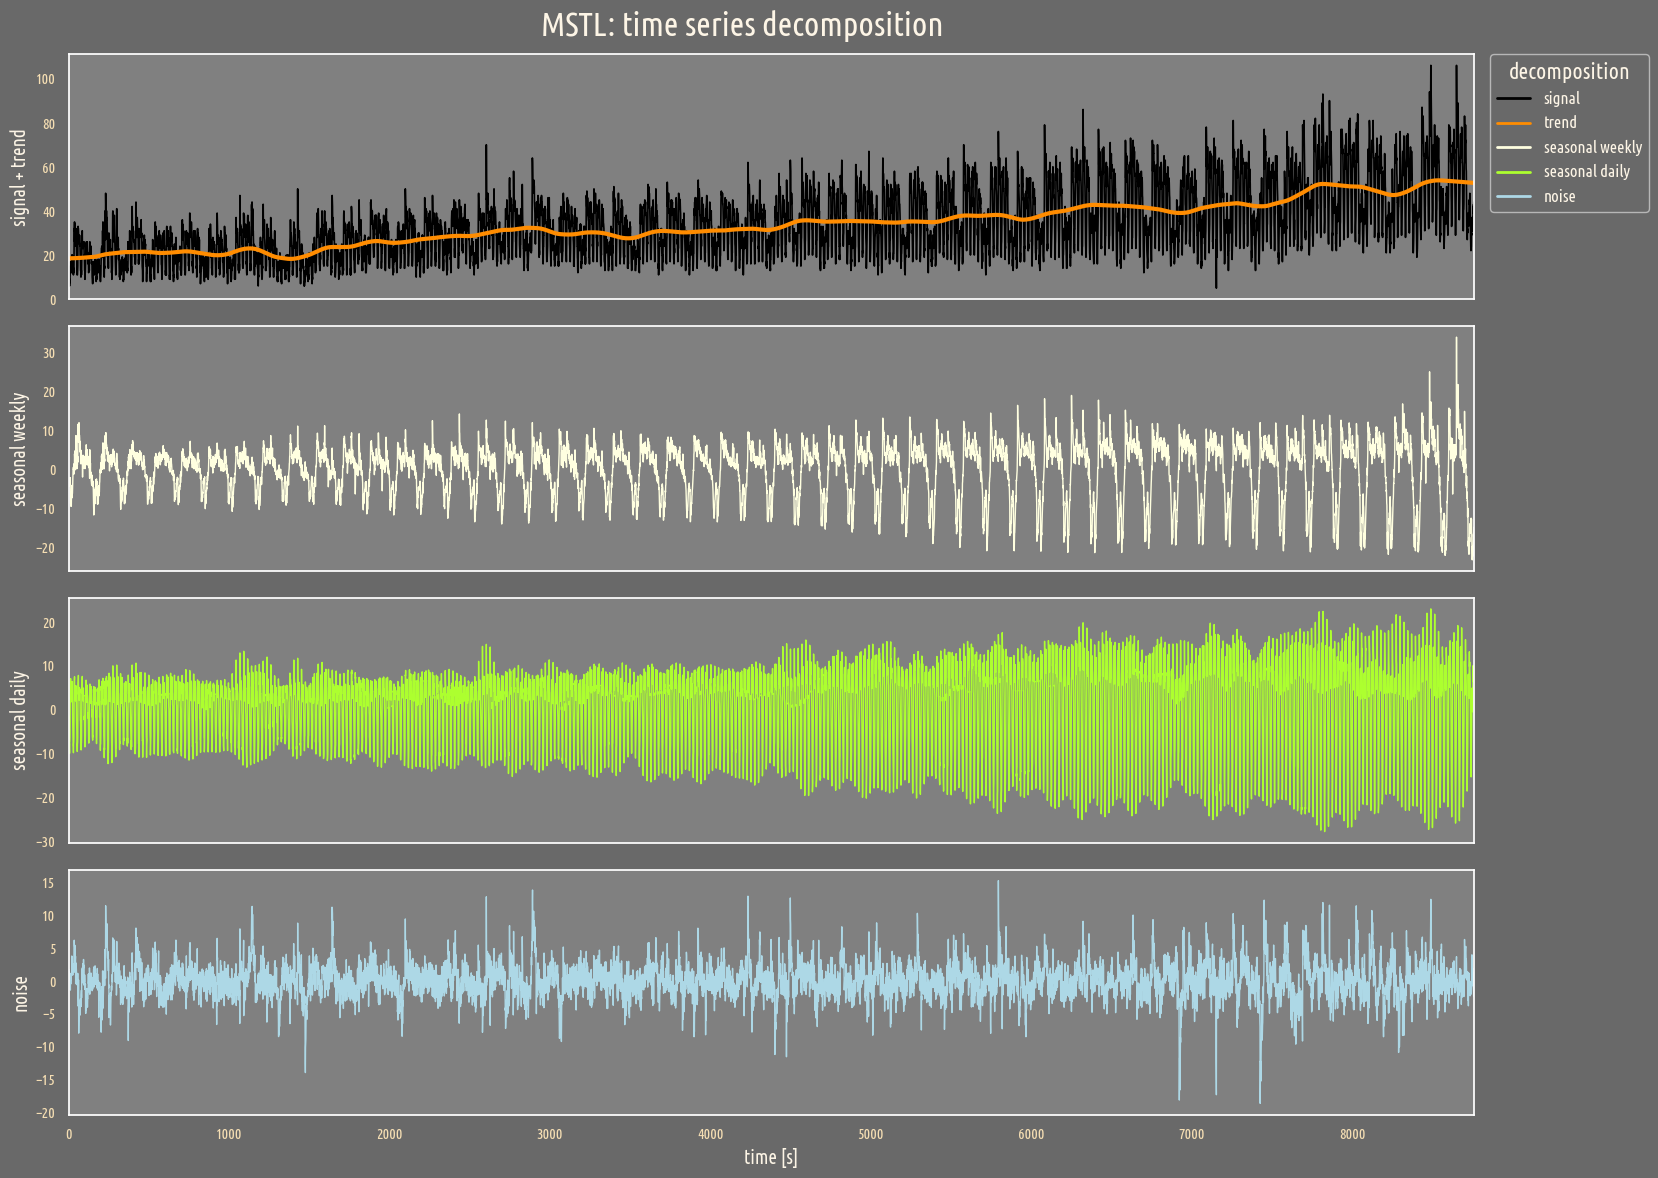

In [531]:
nrows = 4
ncols = 1
fig, axs = plt.subplots(ncols = ncols, nrows=nrows, figsize=(ncols*15,nrows*3), sharex = True)
# fig.set_facecolor("dimgray")

ax = axs[0]
ax.plot(mstl.observed, lw = 1.2, color=signal_color, label = 'signal')
ax.plot(mstl.trend, lw=3, color=trend_color, label='trend')
ax.set_ylabel('signal + trend', fontsize = 14)

ax.set_xlim(0, len(stl.observed))

ax = axs[1]
ax.plot(mstl.seasonal[:,1], lw=1, color=seasonal_color, label='seasonal weekly')
ax.set_ylabel('seasonal weekly', fontsize = 14)

ax = axs[2]
ax.plot(mstl.seasonal[:,0], lw=1, color=seasonal_2_color, label='seasonal daily')
ax.set_ylabel('seasonal daily', fontsize = 14)

ax = axs[3]
ax.plot(mstl.resid, lw=1, color = noise_color, label='noise')
ax.set_ylabel('noise', fontsize = 14)
ax.set_xlabel('time [s]',fontsize = 14)


leg = fig.legend(title='decomposition',bbox_to_anchor = (1.11,.95),title_fontsize = 16,fontsize=12)

for line in leg.get_lines():
    line.set_linewidth(2.0)
    
fig.suptitle('MSTL: time series decomposition', fontsize=24)
fig.tight_layout()

fig.savefig('mstl.png',bbox_inches = 'tight')

In [527]:
fig.savefig?

Signature: fig.savefig(fname, *, transparent=None, **kwargs)
Docstring:
Save the current figure.

Call signature::

  savefig(fname, *, dpi='figure', format=None, metadata=None,
          bbox_inches=None, pad_inches=0.1,
          facecolor='auto', edgecolor='auto',
          backend=None, **kwargs
         )

The available output formats depend on the backend being used.

Parameters
----------
fname : str or path-like or binary file-like
    A path, or a Python file-like object, or
    possibly some backend-dependent object such as
    `matplotlib.backends.backend_pdf.PdfPages`.

    If *format* is set, it determines the output format, and the file
    is saved as *fname*.  Note that *fname* is used verbatim, and there
    is no attempt to make the extension, if any, of *fname* match
    *format*, and no extension is appended.

    If *format* is not set, then the format is inferred from the
    extension of *fname*, if there is one.  If *format* is not
    set and *fname* has no ext

### Fourier

In [516]:
f,xhat_observed,A_observed = fft(mstl.observed)
f,xhat_trend,A_trend = fft(mstl.trend)
f,xhat_seasonal, A_seasonal = fft(mstl.seasonal[:,0])
f,xhat_seasonal_2, A_seasonal_2 = fft(mstl.seasonal[:,1])
f, xhat_resid, A_resid = fft(mstl.resid)

In [517]:
nn = 5
A_observed_ma = scipy.signal.convolve(A_observed,[1/nn]*nn, mode = 'same')
A_trend_ma = scipy.signal.convolve(A_trend,[1/nn]*nn, mode = 'same')
A_seasonal_ma = scipy.signal.convolve(A_seasonal,[1/nn]*nn, mode = 'same')
A_seasonal_2_ma = scipy.signal.convolve(A_seasonal_2,[1/nn]*nn, mode = 'same')
A_resid_ma = scipy.signal.convolve(A_resid,[1/nn]*nn, mode = 'same')

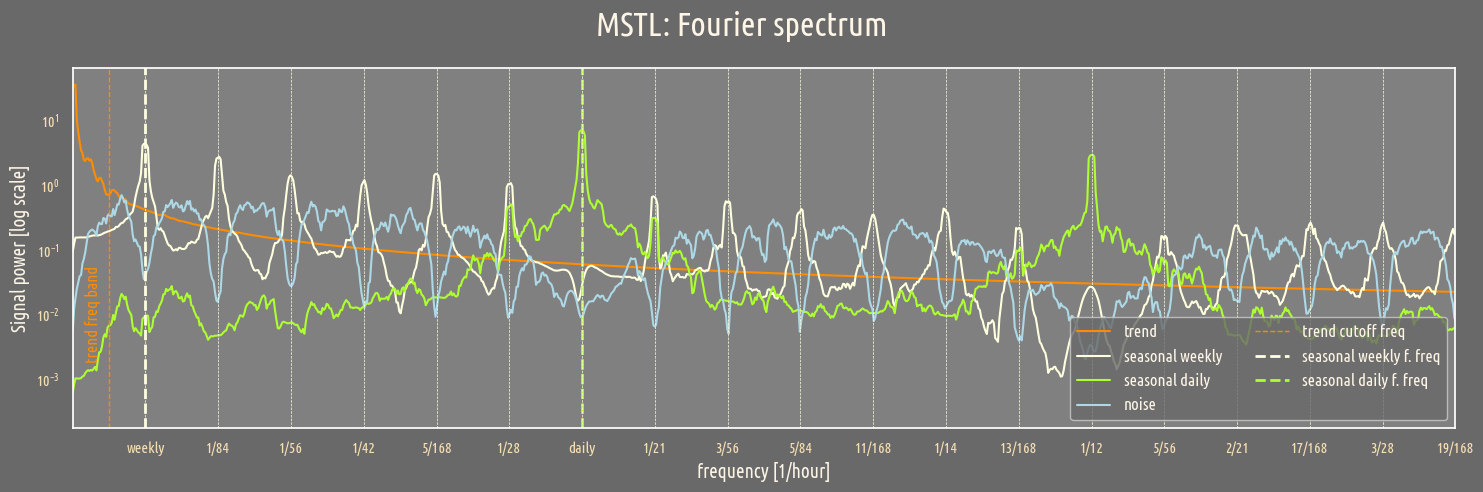

In [526]:
masks = [mask_trend,mask_seasonal,mask_resid]
A_ma = [A_trend_ma,A_seasonal_2_ma,A_seasonal_ma, A_resid_ma]
# A_ = [A_trend,A_seasonal, A_resid]
colors = [trend_color, seasonal_color,seasonal_2_color, noise_color]
labels = ['trend','seasonal weekly', 'seasonal daily', 'noise']
fig, ax = plt.subplots(figsize=(15,5))
# ax.plot(f,A_observed_ma, lw= 0.8, color = signal_color)
# ax.plot(f,np.max(A,axis=0))
for A, color,label in zip(A_ma, colors, labels):
    # ax.plot(f[mask],A_observed_ma[mask],'.',color = color)
    ax.plot(f,A,color = color, label = label)

# ax.plot(f[mask_trend],A_trend[mask_trend],'.', color = trend_color)
# ax.plot(f[mask_seasonal],A_seasonal[mask_seasonal],'.', color = seasonal_color)
# ax.plot(f[mask_resid],A_resid[mask_resid],'.', color = noise_color)
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0,0.1)

ax.axvline(1/trend,ymin=1e-5,ymax=1e2, color = trend_color, ls='--',lw=1, label = 'trend cutoff freq')
ax.axvline(1/periods[0],ymin=1e-5,ymax=1e2, color = seasonal_color, ls='--',lw=2, label = 'seasonal weekly f. freq')
ax.axvline(1/periods[1],ymin=1e-5,ymax=1e2, color = seasonal_2_color, ls='--',lw=2, label = 'seasonal daily f. freq')


for i in range(1,20):
    ax.axvline(i/period,ymin=1e-5,ymax=1e2, color = seasonal_color, ls='--',lw=0.5)
    
y0 = 2e-3  
ax.annotate(text='trend freq band',xy=(0.001,y0),color = trend_color, rotation='vertical')

arrowprops = dict(facecolor=colorK,
                  arrowstyle = 'fancy',
                  
                  shrinkB = 3,
                  shrinkA = 20)

# meanperiod = 1/2*(1/period + 4/period)+0.004

# for i in range(1,5):
#     ax.annotate(text = None, xy = (i/period,1e-2), xytext =(meanperiod,y0), arrowprops=arrowprops)

# ax.text(s = 'seasonal freqs', x =meanperiod, y = y0,horizontalalignment='center',
#         verticalalignment='center')

ax.legend(fontsize=12, loc = 4, ncol=2)


ax.set_xticks([i/(24*7) for i in range(1,20)])
def conv_frac(frac):
    if frac == (1,168):
        return 'weekly'
    elif frac == (1,24):
        return 'daily'
    else:
        return f'{frac[0]}/{frac[1]}'

ax.set_xticklabels([conv_frac(Fraction(i,24*7).as_integer_ratio()) for i in range(1,20)])


ax.set_xlabel('frequency [1/hour]', fontsize = 14)
ax.set_ylabel('Signal power [log scale]', fontsize = 14)

fig.suptitle('MSTL: Fourier spectrum', fontsize=24)

fig.tight_layout()
fig.savefig('mstl_fourier.png')

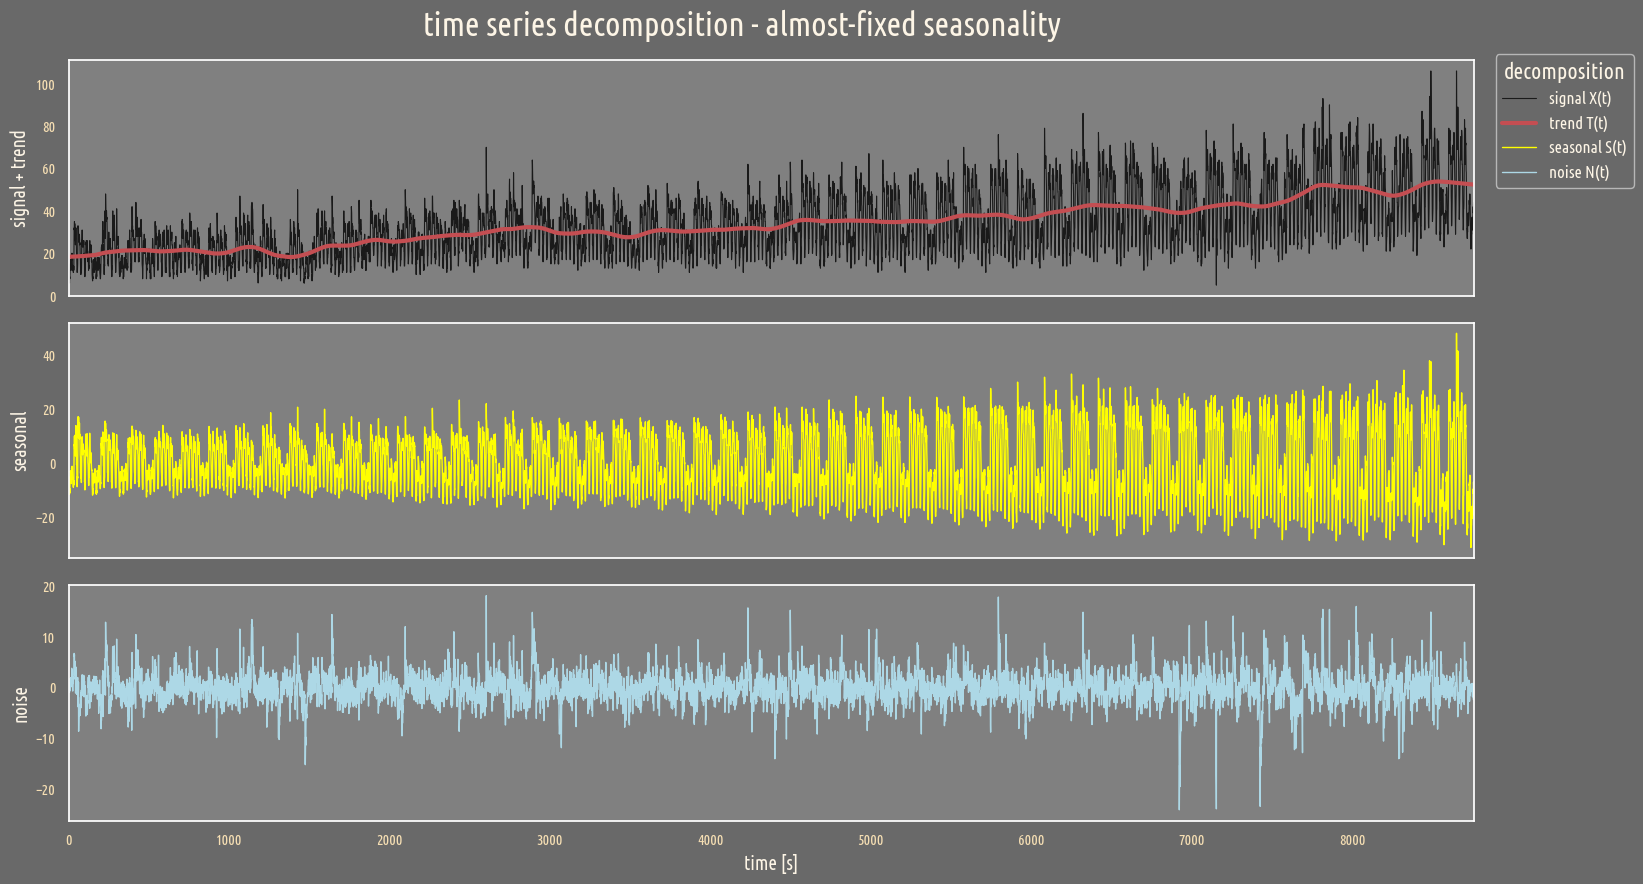

In [409]:
nrows = 3
ncols = 1
fig, axs = plt.subplots(ncols = ncols, nrows=nrows, figsize=(ncols*15,nrows*3), sharex = True)

ax = axs[0]
ax.plot(stl.observed, lw = 0.8, color='k', label = 'signal X(t)')
ax.plot(stl.trend, lw=3, color='r', label='trend T(t)')
ax.set_ylabel('signal + trend', fontsize = 14)

ax.set_xlim(0, len(sd.observed))

ax = axs[1]
ax.plot(stl.seasonal, lw=1, color='yellow', label='seasonal S(t)')
ax.set_ylabel('seasonal', fontsize = 14)

ax = axs[2]
ax.plot(stl.resid, lw=1, color = 'lightblue', label='noise N(t)')
ax.set_ylabel('noise', fontsize = 14)
ax.set_xlabel('time [s]',fontsize = 14)


fig.legend(title='decomposition',bbox_to_anchor = (1.1,.94),title_fontsize = 16,fontsize=12)

fig.suptitle('time series decomposition - almost-fixed seasonality', fontsize=24)
fig.tight_layout()

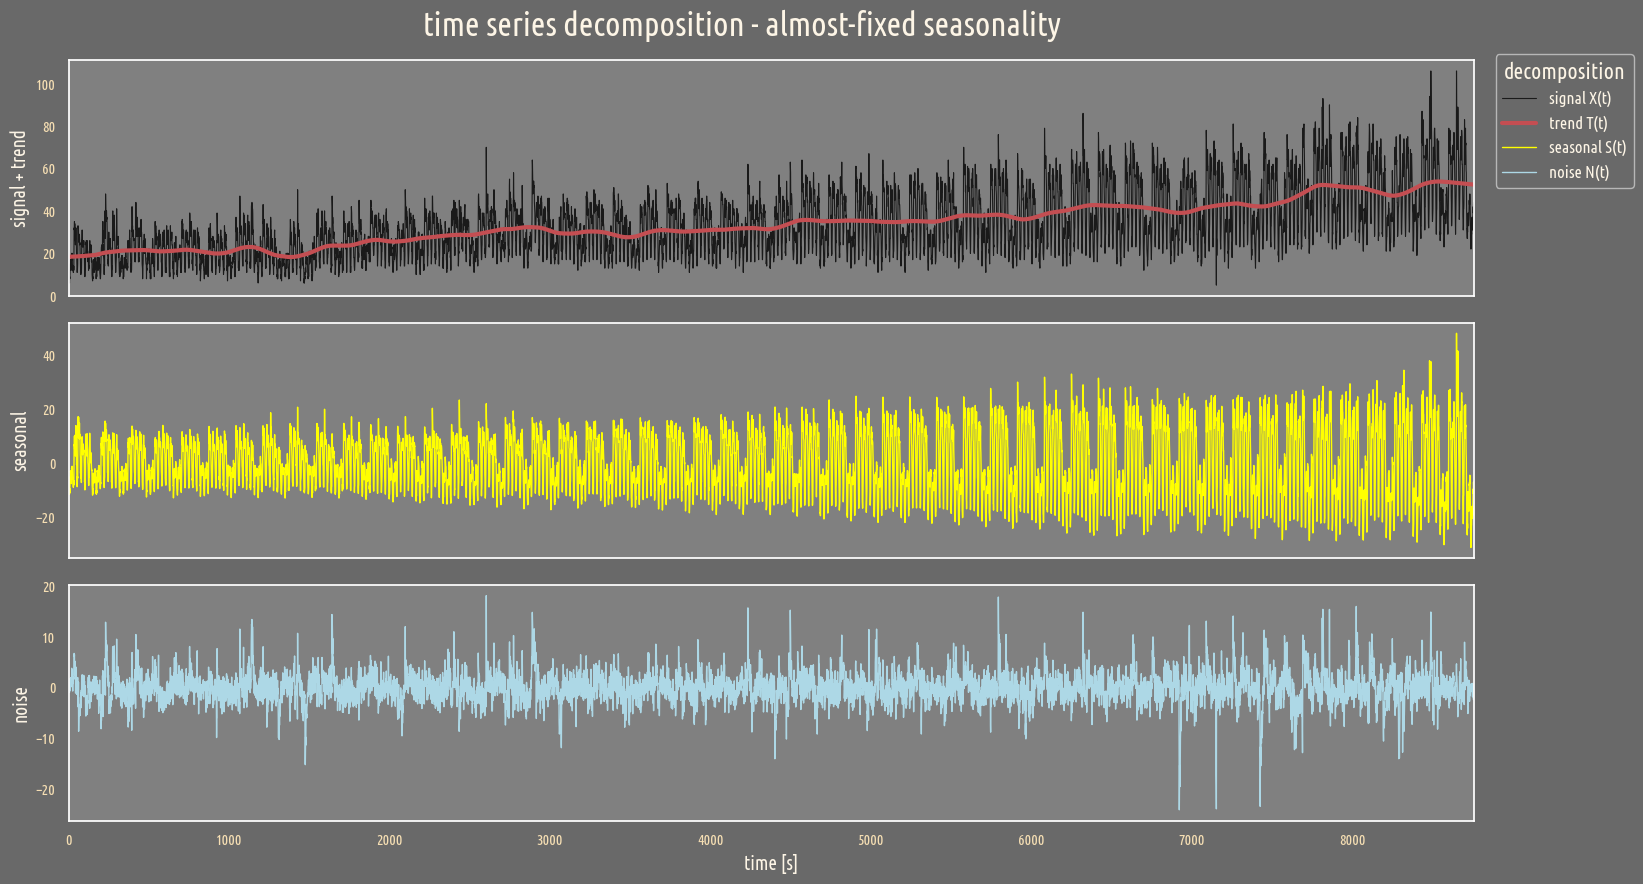

In [409]:
nrows = 3
ncols = 1
fig, axs = plt.subplots(ncols = ncols, nrows=nrows, figsize=(ncols*15,nrows*3), sharex = True)

ax = axs[0]
ax.plot(stl.observed, lw = 0.8, color='k', label = 'signal X(t)')
ax.plot(stl.trend, lw=3, color='r', label='trend T(t)')
ax.set_ylabel('signal + trend', fontsize = 14)

ax.set_xlim(0, len(sd.observed))

ax = axs[1]
ax.plot(stl.seasonal, lw=1, color='yellow', label='seasonal S(t)')
ax.set_ylabel('seasonal', fontsize = 14)

ax = axs[2]
ax.plot(stl.resid, lw=1, color = 'lightblue', label='noise N(t)')
ax.set_ylabel('noise', fontsize = 14)
ax.set_xlabel('time [s]',fontsize = 14)


fig.legend(title='decomposition',bbox_to_anchor = (1.1,.94),title_fontsize = 16,fontsize=12)

fig.suptitle('time series decomposition - almost-fixed seasonality', fontsize=24)
fig.tight_layout()

In [810]:
(np.abs(stl.seasonal + stl.trend + stl.resid - stl.observed) < 1e-10).all()

True

In [811]:
import scipy.signal

In [812]:
def fft(x):
    xhat = scipy.fft.fft(x)
    xhat = xhat[:len(xhat)//2]
    f = scipy.fft.fftfreq(n=len(x),d=1)
    f = f[:len(f)//2]
    A = np.abs(xhat)
    # A = A[:len(A)//2]
    
    return f, xhat, A

In [813]:
mask = (~np.isnan(sd.trend))
f,xhat_observed,A_observed = fft(sd.observed[mask])
f,xhat_trend,A_trend = fft(sd.trend[mask])
f,xhat_seasonal, A_seasonal = fft(sd.seasonal[mask])
f, xhat_resid, A_resid = fft(sd.resid[mask])

In [814]:
(np.abs(np.abs(xhat_observed) - np.abs(xhat_trend + xhat_seasonal + xhat_resid)) < 1e-10).all()

True

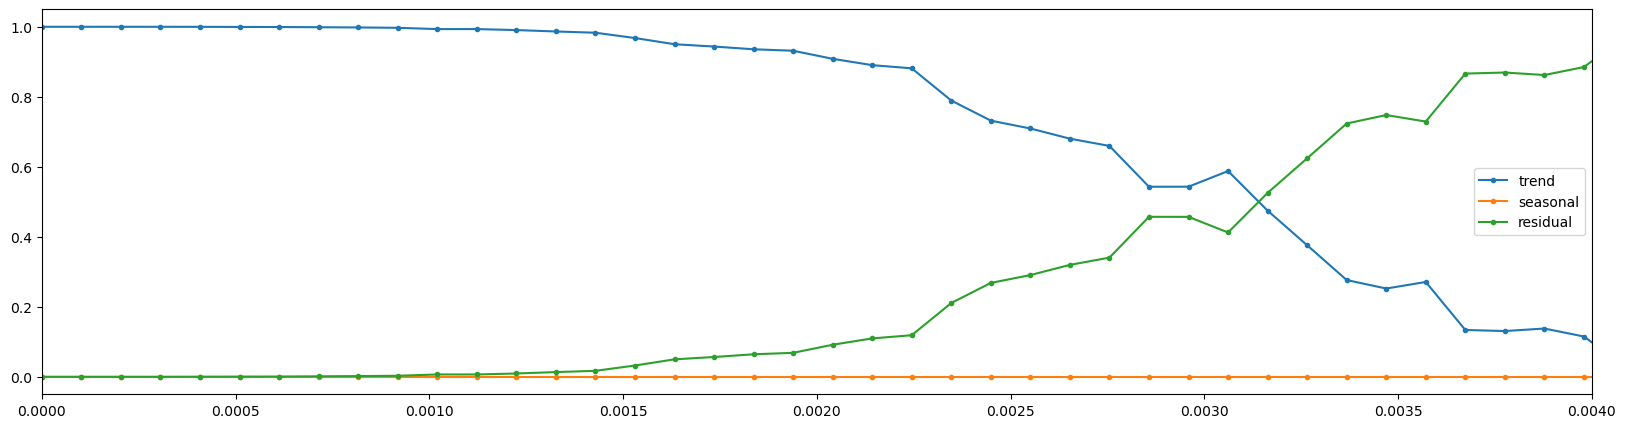

In [815]:
fig, ax = plt.subplots(figsize=(20,5))

ax.plot(f, A_trend**2/(A_trend**2 + A_seasonal**2 + A_resid**2),'.-',label = 'trend')
ax.plot(f, A_seasonal**2/(A_trend**2 + A_seasonal**2 + A_resid**2),'.-', label = 'seasonal')
ax.plot(f, A_resid**2/(A_trend**2 + A_seasonal**2 + A_resid**2),'.-', label = 'residual')

# ax.set_xscale('log')
ax.set_xlim(0,0.004)
ax.legend()

In [816]:
data = pd.DataFrame({'f':f, 'A_trend': A_trend**2, 'A_seasonal': A_seasonal**2, 'A_resid': A_resid**2})

subdata = data[data['f'] < 0.025].copy()

subdata['A_total'] = subdata['A_trend'] + subdata['A_seasonal'] + subdata['A_resid']

subdata['f'] = subdata['f'].apply(lambda x: f'{x:.4f}')

In [817]:
for col in ['A_trend','A_seasonal','A_resid']:
    subdata[col] /= subdata['A_total']

<Axes: xlabel='f'>

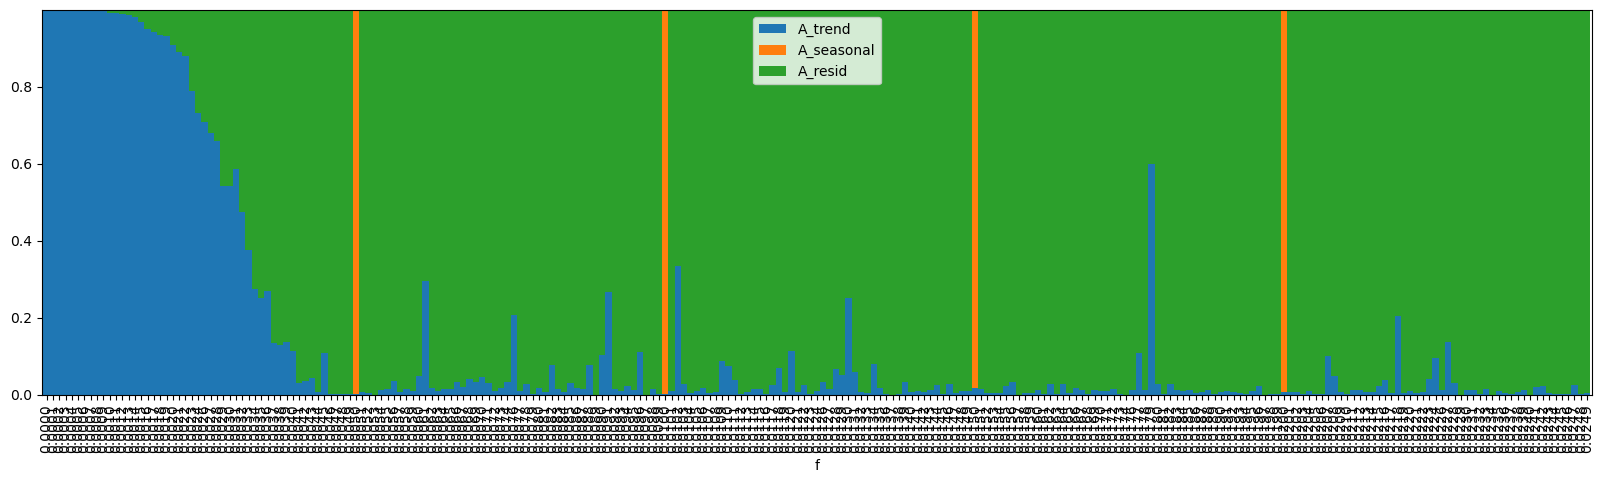

In [818]:
fig, ax = plt.subplots(figsize=(20,5))
subdata.plot(x='f',y=['A_trend','A_seasonal','A_resid'],kind='bar',stacked=True, width = 1, ax = ax)

# ax.set_xticklabels(ax.get_xticklabels()[::5])

In [819]:
period = 200
trend = 501
seasonal = 21
stl = statsmodels.tsa.seasonal.STL(endog = x,period = period,trend = trend,seasonal = seasonal)
stl = stl.fit()

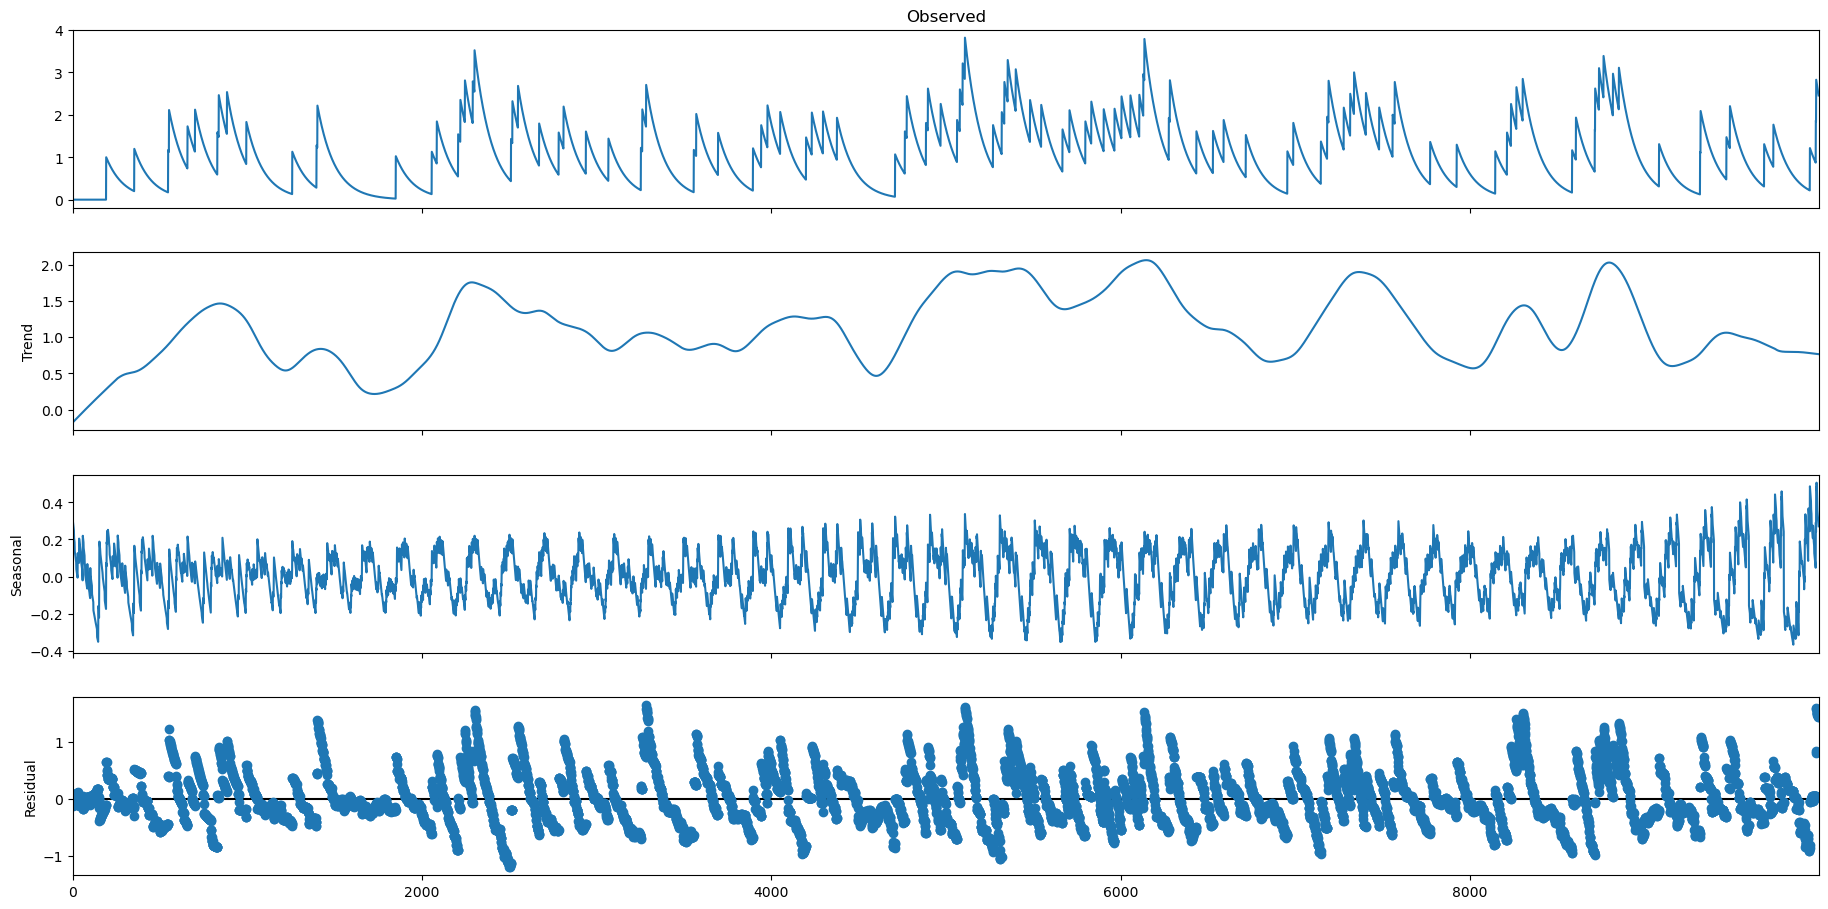

In [820]:
fig = stl.plot()
fig.set_figwidth(20)
fig.set_figheight(10)

In [821]:
mask = (~np.isnan(stl.trend))
f,xhat_observed,A_observed = fft(stl.observed[mask])
f,xhat_trend,A_trend = fft(stl.trend[mask])
f,xhat_seasonal, A_seasonal = fft(stl.seasonal[mask])
f, xhat_resid, A_resid = fft(stl.resid[mask])

In [822]:
data = pd.DataFrame({'f':f, 'A_trend': A_trend**2, 'A_seasonal': A_seasonal**2, 'A_resid': A_resid**2})

fmax = 0.025
subdata = data[data['f'] < fmax].copy()

subdata['A_total'] = subdata['A_trend'] + subdata['A_seasonal'] + subdata['A_resid']

subdata['f'] = subdata['f'].apply(lambda x: f'{x:.4f}')

In [823]:
for col in ['A_trend','A_seasonal','A_resid']:
    subdata[col] /= subdata['A_total']

<bound method Artist.set_label of <Axes: xlabel='f'>>

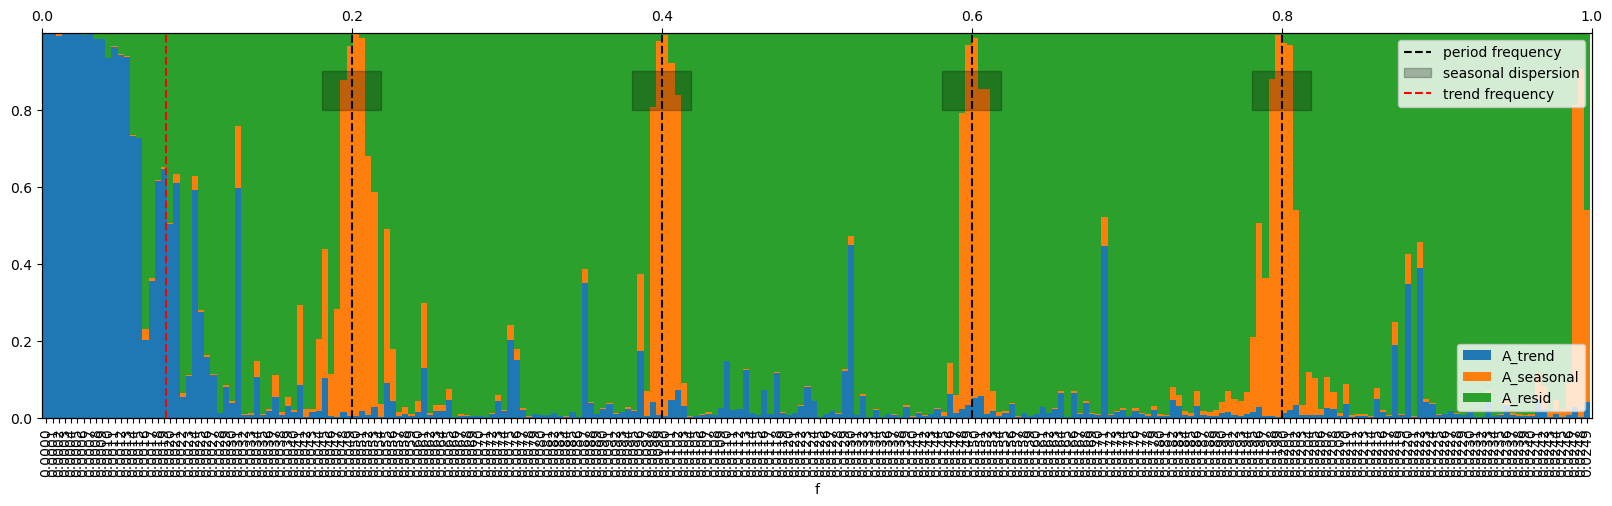

In [824]:
fig, ax = plt.subplots(figsize=(20,5))
subdata.plot(x='f',y=['A_trend','A_seasonal','A_resid'],kind='bar',stacked=True, width = 1, ax = ax)

ax2 = ax.twiny()

label = 'period frequency'
label2 = 'seasonal dispersion'
for i in range(1,5):
    ax2.axvline(1/fmax*i/period,ymin=0,ymax=1, label=label,ls='--',c='k')
    label = None
    # print(1/fmax*(i/period - 1/seasonal/1000),1/fmax*(i/period + 1/seasonal/1000))
    ax2.fill_betweenx(y = [0.8,0.9],
                      x1 = 1/fmax*(i/period - 1/seasonal/100), 
                      x2 = 1/fmax*(i/period + 1/seasonal/100),
                      alpha = 0.25,
                      color = 'k',label=label2)
    label2 = None
    
ax2.set_xlim(0,1)

ax2.axvline(1/fmax*1/trend,ymin=0,ymax=1, label='trend frequency',ls='--',c='r')
# ax2.axvline(1,ymin=0,ymax=1, label='period')
ax2.legend()
ax.legend(loc=4)
ax.set_label
# ax.set_xticklabels(ax.get_xticklabels()[::5])

In [859]:
statsmodels.tsa.seasonal.MSTL?

Init signature:
statsmodels.tsa.seasonal.MSTL(
    endog: Any,
    *,
    periods: Union[int, Sequence[int], NoneType] = None,
    windows: Union[int, Sequence[int], NoneType] = None,
    lmbda: Union[float, str, NoneType] = None,
    iterate: int = 2,
    stl_kwargs: Optional[Dict[str, Union[int, bool, NoneType]]] = None,
)
Docstring:     
MSTL(endog, periods=None, windows=None, lmbda=None, iterate=2,
     stl_kwargs=None)

Season-Trend decomposition using LOESS for multiple seasonalities.

.. versionadded:: 0.14.0

Parameters
----------
endog : array_like
    Data to be decomposed. Must be squeezable to 1-d.
periods : {int, array_like, None}, optional
    Periodicity of the seasonal components. If None and endog is a pandas
    Series or DataFrame, attempts to determine from endog. If endog is a
    ndarray, periods must be provided.
windows : {int, array_like, None}, optional
    Length of the seasonal smoothers for each corresponding period.
    Must be an odd integer, and should n

In [860]:
periods = [200,230]
trend = 501
windows = [21, 31]
mstl = statsmodels.tsa.seasonal.MSTL(endog = x,periods = periods, windows= windows, stl_kwargs = dict(trend = trend))
mstl = mstl.fit()

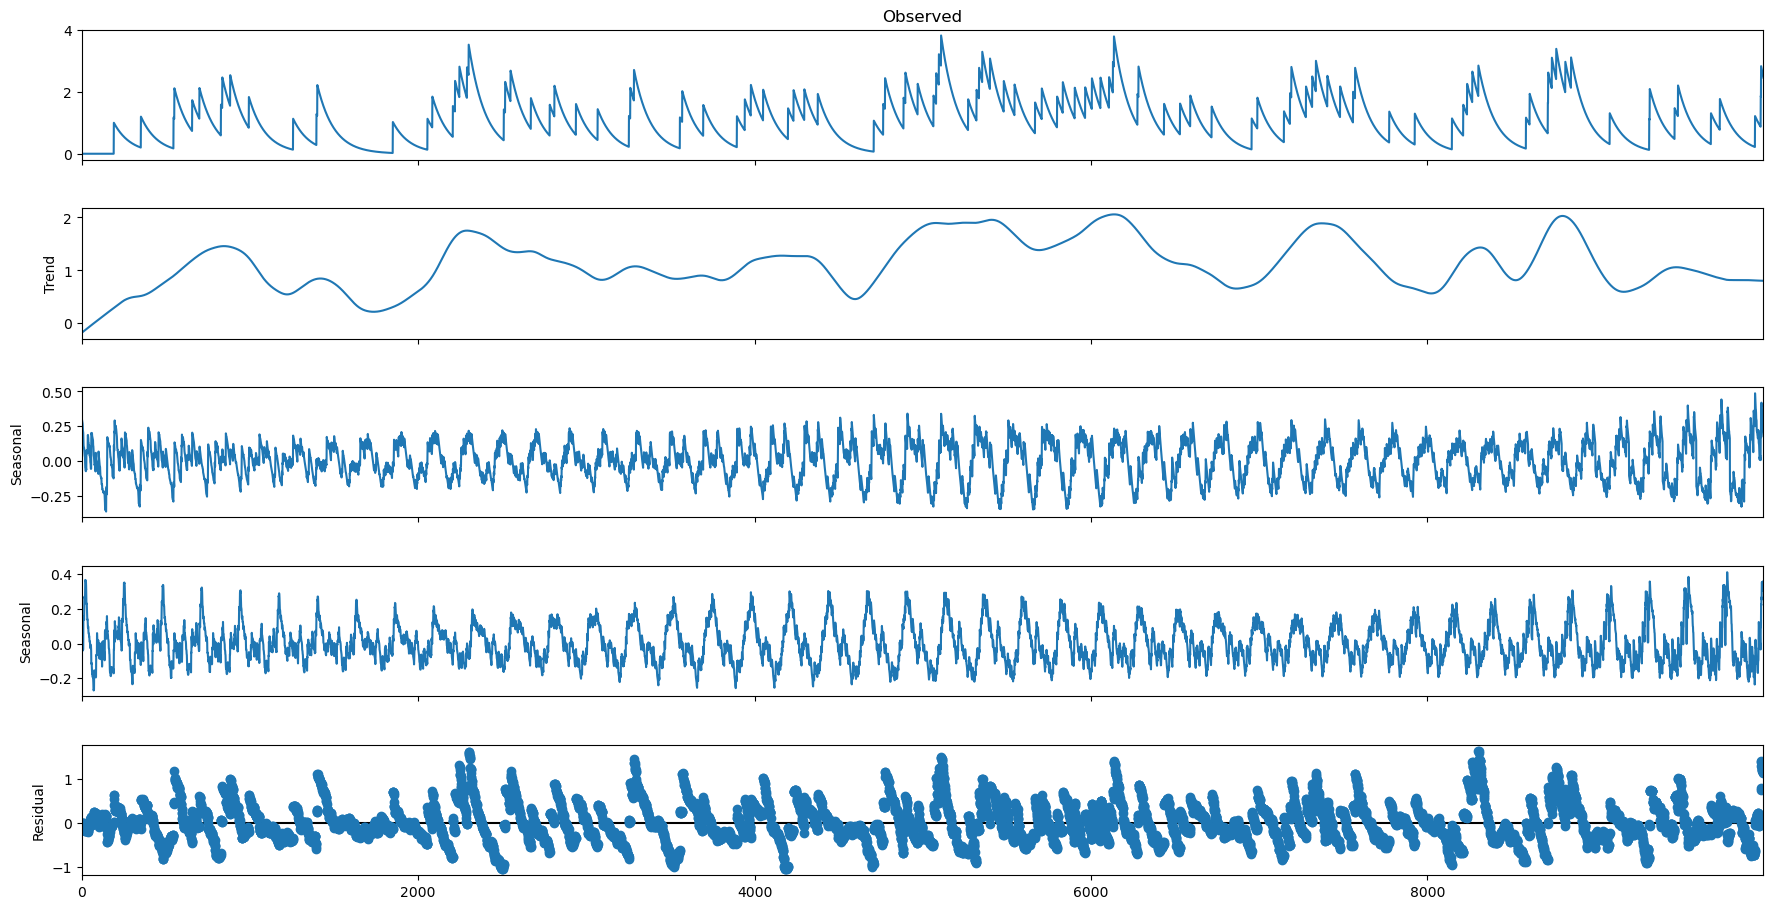

In [861]:
fig = mstl.plot()
fig.set_figwidth(20)
fig.set_figheight(10)

In [862]:
mask = (~np.isnan(mstl.trend))
f,xhat_observed,A_observed = fft(mstl.observed[mask])
f,xhat_trend,A_trend = fft(mstl.trend[mask])
f,xhat_seasonal, A_seasonal = fft(mstl.seasonal[mask,0])
f,xhat_seasonal_2, A_seasonal_2 = fft(mstl.seasonal[mask,1])
f, xhat_resid, A_resid = fft(mstl.resid[mask])

In [863]:
data = pd.DataFrame({'f':f, 'A_trend': A_trend**2, 'A_seasonal': A_seasonal**2,'A_seasonal_2': A_seasonal_2**2, 'A_resid': A_resid**2})

fmax = 0.025
subdata = data[data['f'] < fmax].copy()

subdata['A_total'] = subdata['A_trend'] + subdata['A_seasonal'] + subdata['A_seasonal_2'] + subdata['A_resid']

subdata['f'] = subdata['f'].apply(lambda x: f'{x:.4f}')

In [864]:
for col in ['A_trend','A_seasonal','A_seasonal_2','A_resid']:
    subdata[col] /= subdata['A_total']

<bound method Artist.set_label of <Axes: xlabel='f'>>

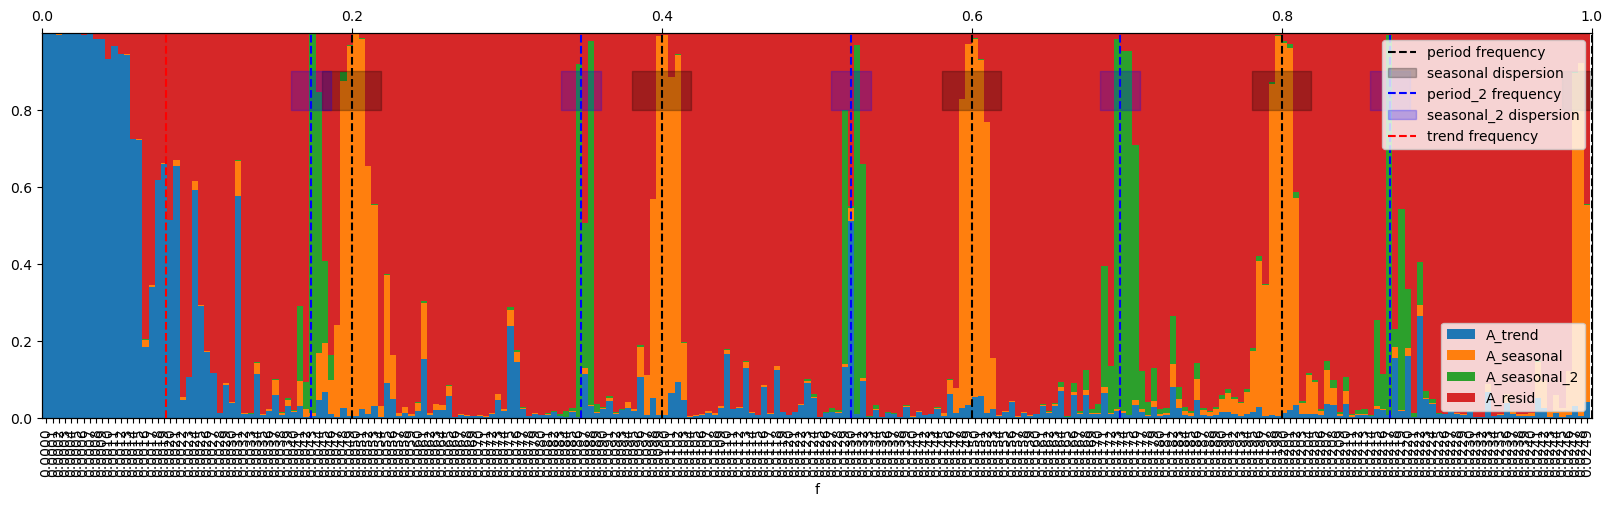

In [865]:
fig, ax = plt.subplots(figsize=(20,5))
subdata.plot(x='f',y=['A_trend','A_seasonal','A_seasonal_2','A_resid'],kind='bar',stacked=True, width = 1, ax = ax)

ax2 = ax.twiny()

colors = ['k','b']
for period, window, ptitle,title, c in zip(periods, windows,['period','period_2'],['seasonal', 'seasonal_2'], colors):
    label = f'{ptitle} frequency'
    label2 = f'{title} dispersion'
    for i in range(1,int(1/fmax)):
        ax2.axvline(1/fmax*i/period,ymin=0,ymax=1, label=label,ls='--',c=c)
        label = None
        # print(1/fmax*(i/period - 1/seasonal/1000),1/fmax*(i/period + 1/seasonal/1000))
        ax2.fill_betweenx(y = [0.8,0.9],
                          x1 = 1/fmax*(i/period - 1/window/100), 
                          x2 = 1/fmax*(i/period + 1/window/100),
                          alpha = 0.25,
                          color = c,label=label2)
        label2 = None

ax2.set_xlim(0,1)

ax2.axvline(1/fmax*1/trend,ymin=0,ymax=1, label='trend frequency',ls='--',c='r')
# ax2.axvline(1,ymin=0,ymax=1, label='period')
ax2.legend()
ax.legend(loc=4)
ax.set_label
# ax.set_xticklabels(ax.get_xticklabels()[::5])

## post

In [1436]:
import matplotlib

In [1004]:
df.columns

Index(['index', 'aimp', 'amud', 'arnd', 'asin1', 'asin2', 'adbr', 'adfl',
       'bed1', 'bed2', 'bfo1', 'bfo2', 'bso1', 'bso2', 'bso3', 'ced1', 'cfo1',
       'cso1', 'y', 'category'],
      dtype='object')

In [1258]:
subdf = df.iloc[:25000]
col = 'arnd'
# subdf = df.iloc[:10000]
# col = 'bed1'
# subdf = df.iloc[:10000]
# col = 'bed2'
# subdf = df.iloc[:10000]
# col = 'y'

In [1259]:
x = subdf[col]
x = x.to_numpy()

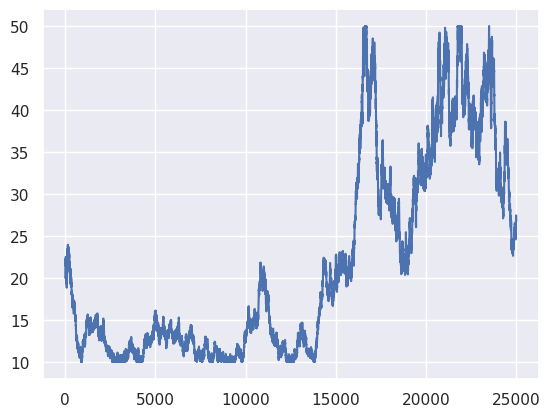

In [1260]:
plt.plot(x)

In [1465]:
f,xhat_observed,A_observed = fft(sd.observed)
f,xhat_trend,A_trend = fft(sd.trend)
f,xhat_seasonal, A_seasonal = fft(sd.seasonal)
f, xhat_resid, A_resid = fft(sd.resid)

In [1466]:
data = pd.DataFrame({'f':f, 'A_trend': A_trend**2, 'A_seasonal': A_seasonal**2, 'A_resid': A_resid**2})

fmax = 0.01
subdata = data[data['f'] < fmax].copy()
subdata['A_total'] = subdata['A_trend'] + subdata['A_seasonal'] + subdata['A_resid']

subdata['f'] = subdata['f'].apply(lambda x: f'{x:.3f}')

In [1467]:
for col in ['A_trend','A_seasonal','A_resid']:
    subdata[col] /= subdata['A_total']

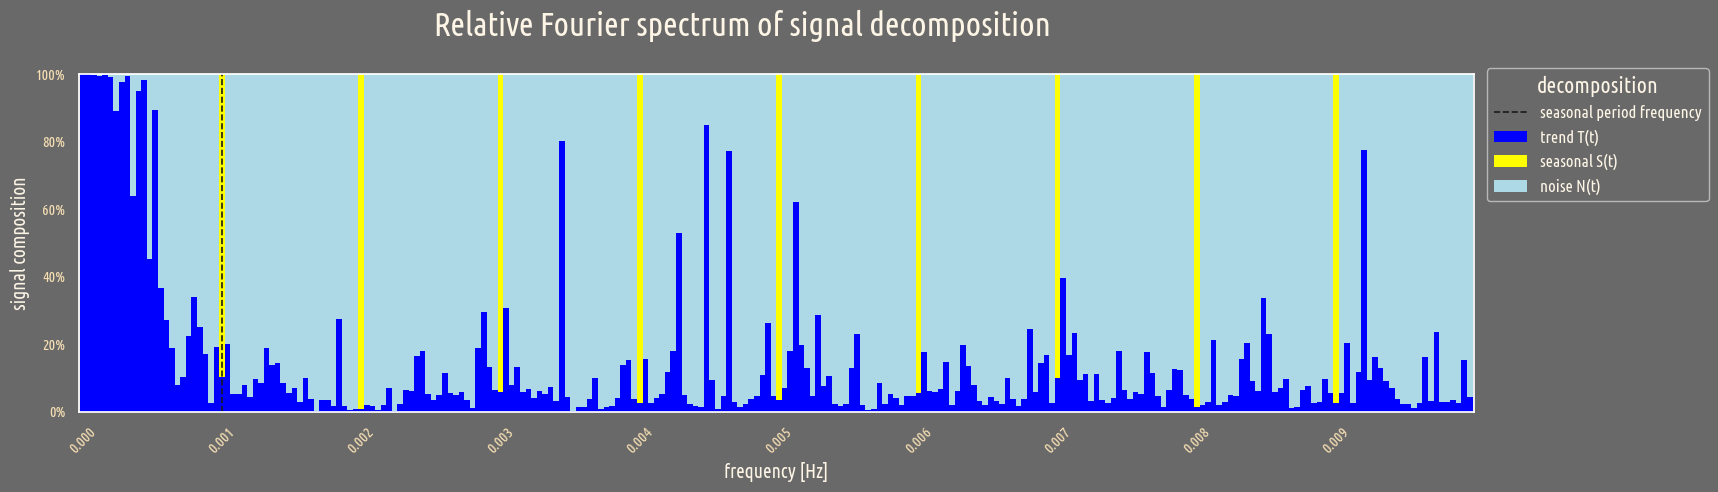

In [1475]:
fig, ax = plt.subplots(figsize=(15,5))
subdata.plot(x='f',y=['A_trend','A_seasonal','A_resid'],kind='bar',stacked=True, width = 1,  color = ['blue','yellow','lightblue'],edgecolor='black',linewidth=0, rot = 45, ax = ax)

fig.suptitle('Relative Fourier spectrum of signal decomposition', fontsize=24)

xticks = ax.get_xticks()
xlabels = ax.get_xticklabels()
_ = ax.set_xticks(xticks[::25],xlabels[::25])
ax.set_xlabel('frequency [Hz]', fontsize = 14)


yticks = ax.get_yticks()
ylabels = ax.get_yticklabels()
for a in ylabels:
    a.set_text(f'{100*a.get_position()[1]:.0f}%')
ax.set_yticks(yticks,ylabels)
ax.set_ylabel('signal composition',fontsize = 14)

ax.get_legend().remove()

# ax2 = ax.twiny()

label = 'seasonal period frequency'
for ix in xticks[::25][1:2]:
    ax.axvline(ix,ymin=0,ymax=1, label=label,ls='--',lw = 1.2, c='k')
    label = None

l = fig.legend(title='decomposition',bbox_to_anchor = (1.15,.88),title_fontsize = 16,fontsize=12)

l.get_texts()[1].set_text('trend T(t)')
l.get_texts()[2].set_text('seasonal S(t)')
l.get_texts()[3].set_text('noise N(t)')
# for t in l.get_texts():
#     text  = t.get_text()
    
#     t.set_text('make it short')

fig.tight_layout()
# ax.axvlin1/period,ymin=0,ymax=1, label=label,ls='--',c='k')
# ax.set_xticklabels(ax.get_xticklabels()[::5])

In [1299]:
period = 1000
trend = 2001
seasonal = 21
stl = statsmodels.tsa.seasonal.STL(endog = x,period = period,trend = trend,seasonal = seasonal)
stl = stl.fit()

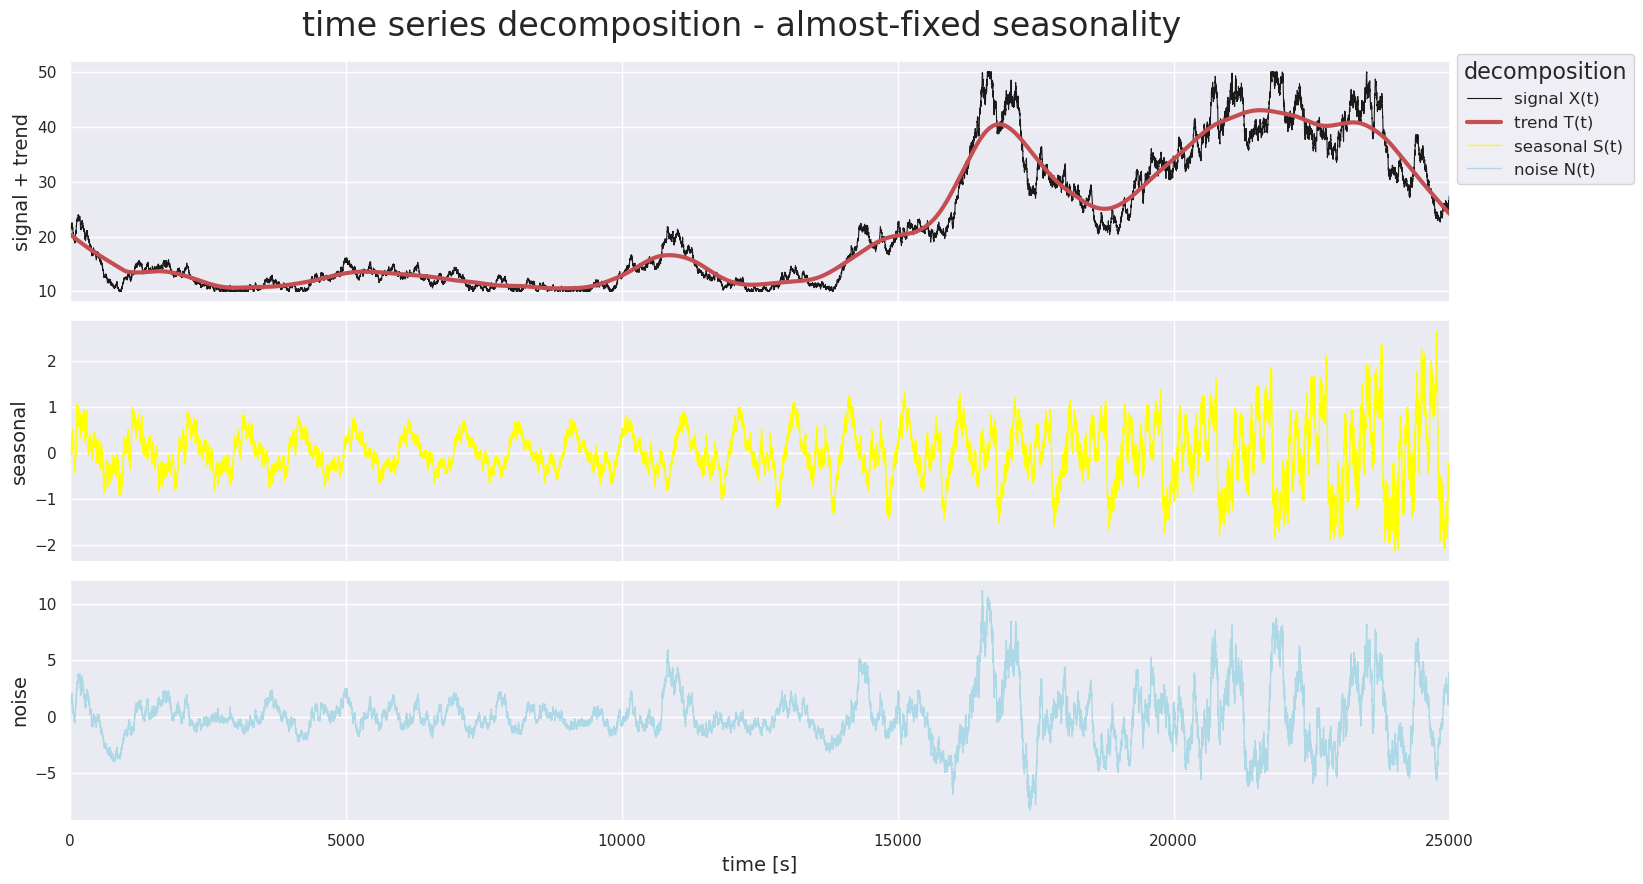

In [1300]:
nrows = 3
ncols = 1
fig, axs = plt.subplots(ncols = ncols, nrows=nrows, figsize=(ncols*15,nrows*3), sharex = True)

ax = axs[0]
ax.plot(stl.observed, lw = 0.8, color='k', label = 'signal X(t)')
ax.plot(stl.trend, lw=3, color='r', label='trend T(t)')
ax.set_ylabel('signal + trend', fontsize = 14)

ax.set_xlim(0, len(sd.observed))

ax = axs[1]
ax.plot(stl.seasonal, lw=1, color='yellow', label='seasonal S(t)')
ax.set_ylabel('seasonal', fontsize = 14)

ax = axs[2]
ax.plot(stl.resid, lw=1, color = 'lightblue', label='noise N(t)')
ax.set_ylabel('noise', fontsize = 14)
ax.set_xlabel('time [s]',fontsize = 14)


fig.legend(title='decomposition',bbox_to_anchor = (1.1,.94),title_fontsize = 16,fontsize=12)

fig.suptitle('time series decomposition - almost-fixed seasonality', fontsize=24)
fig.tight_layout()

In [1301]:
f,xhat_observed,A_observed = fft(stl.observed)
f,xhat_trend,A_trend = fft(stl.trend)
f,xhat_seasonal, A_seasonal = fft(stl.seasonal)
f, xhat_resid, A_resid = fft(stl.resid)

In [1302]:
data = pd.DataFrame({'f':f, 'A_trend': A_trend**2, 'A_seasonal': A_seasonal**2, 'A_resid': A_resid**2})

fmax = 0.01
subdata = data[data['f'] < fmax].copy()

subdata['A_total'] = subdata['A_trend'] + subdata['A_seasonal'] + subdata['A_resid']

subdata['f'] = subdata['f'].apply(lambda x: f'{x:.4f}')

In [1303]:
for col in ['A_trend','A_seasonal','A_resid']:
    subdata[col] /= subdata['A_total']

In [1304]:
ax2 = ax.twiny()

label = 'period frequency'
label2 = 'seasonal dispersion'
for i in range(1,5):
    ax2.axvline(1/fmax*i/period,ymin=0,ymax=1, label=label,ls='--',c='k')
    label = None
    # print(1/fmax*(i/period - 1/seasonal/1000),1/fmax*(i/period + 1/seasonal/1000))

    label2 = None
    
ax2.set_xlim(0,1)

(0.0, 1.0)

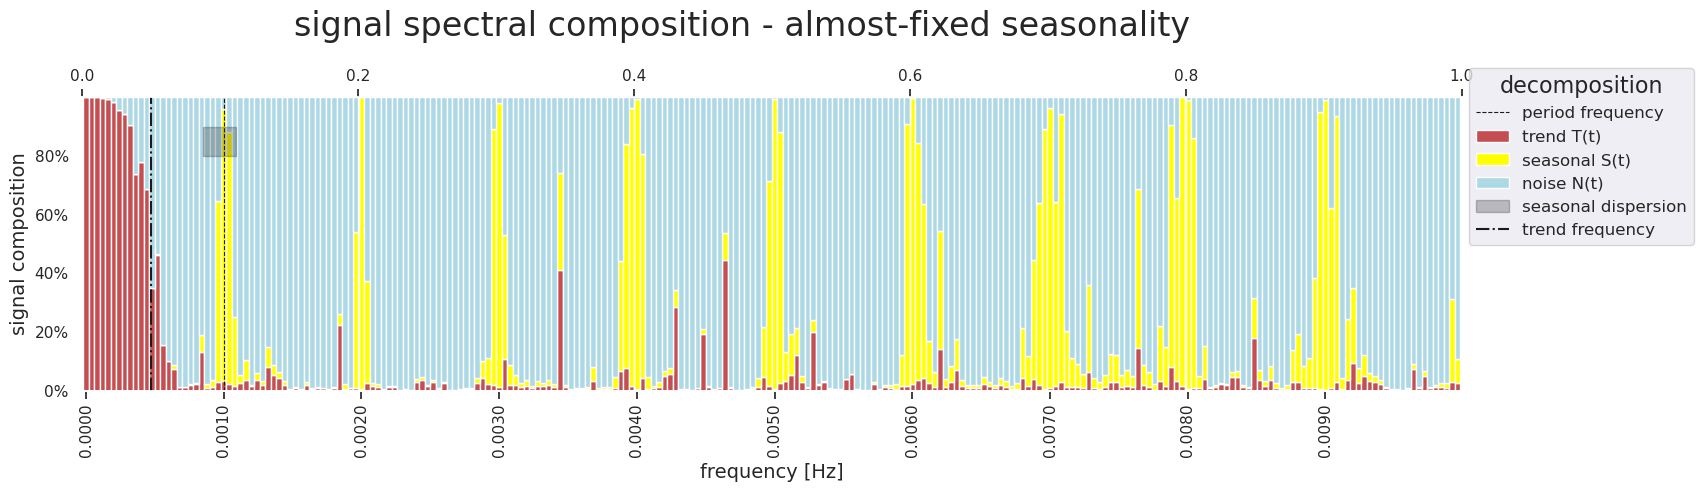

In [1312]:
fig, ax = plt.subplots(figsize=(15,5))
subdata.plot(x='f',y=['A_trend','A_seasonal','A_resid'],kind='bar',stacked=True, width = 1,  color = ['r','yellow','lightblue'], ax = ax)

fig.suptitle('signal spectral composition - almost-fixed seasonality', fontsize=24)

xticks = ax.get_xticks()
xlabels = ax.get_xticklabels()
_ = ax.set_xticks(xticks[::25],xlabels[::25])
ax.set_xlabel('frequency [Hz]', fontsize = 14)


yticks = ax.get_yticks()
ylabels = ax.get_yticklabels()
for a in ylabels:
    a.set_text(f'{100*a.get_position()[1]:.0f}%')
ax.set_yticks(yticks,ylabels)
ax.set_ylabel('signal composition',fontsize = 14)

ax.get_legend().remove()

# ax2 = ax.twiny()


label = 'period frequency'
for ix in xticks[::25][1:2]:
    ax.axvline(ix,ymin=0,ymax=1, label=label,ls='--',lw = 0.8, c='k')
    label = None

    
ax2 = ax.twiny()
label2 = 'seasonal dispersion'
ax2.fill_betweenx(y = [0.8,0.9],
                  x1 = 1/fmax*(1/period- 1/seasonal/400), 
                  x2 = 1/fmax*(1/period  + 1/seasonal/400),
                  alpha = 0.25,
                  color = 'k',label=label2)
label2 = None

ax2.axvline(1/fmax*1/trend,ymin=0,ymax=1, label='trend frequency',ls='-.',c='k')

ax2.set_xlim(0,1)


l = fig.legend(title='decomposition',bbox_to_anchor = (1.14,.88),title_fontsize = 16,fontsize=12)



l.get_texts()[1].set_text('trend T(t)')
l.get_texts()[2].set_text('seasonal S(t)')
l.get_texts()[3].set_text('noise N(t)')


fig.tight_layout()
# ax.axvlin1/period,ymin=0,ymax=1, label=label,ls='--',c='k')
# ax.set_xticklabels(ax.get_xticklabels()[::5])

In [1310]:
seasonal/period

0.021

In [1431]:
dt = 0.001
t = np.arange(0,100,dt)

nu0 = 1
# omega1 = np.pi
nu1 = 3.11

F = np.sin(2*np.pi*nu0*t) + np.sin(2*np.pi*nu1*t)
f, Fhat, Ahat = fft(F,dt=dt)

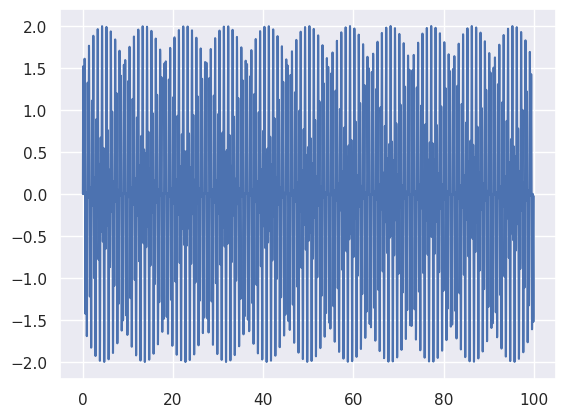

In [1428]:
plt.plot(t,F)

(0.0, 4.0)

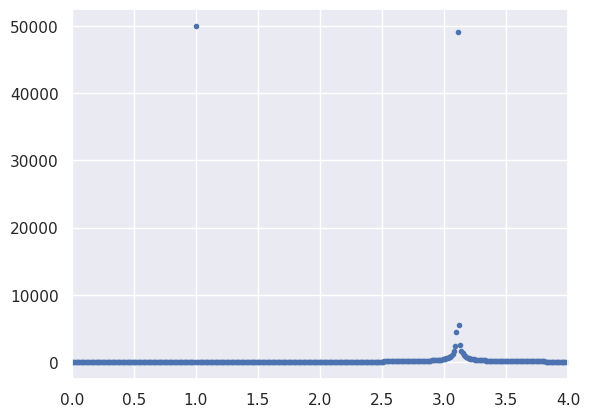

In [1426]:
plt.plot(f,Ahat,'.')
plt.xlim(0,4)